# 🚀 MalthusJAX Level 3 Engine Architecture Demo

**Complete demonstration of MalthusJAX's Level 3 evolutionary computation framework**

This notebook showcases the complete Level 3 architecture of MalthusJAX, featuring:

- 🏗️ **Abstract Engine Foundation**: Base classes and contracts for all evolutionary engines
- 🧬 **Concrete Genetic Algorithm**: Complete GA implementation with modular operator composition
- 📊 **Universal Visualization**: Engine-agnostic visualization tools with advanced analytics
- 🔬 **Multi-Run Analysis**: Comprehensive statistical analysis and functional data analysis
- ⚡ **JAX Performance**: JIT compilation, GPU acceleration, and performance benchmarking
- 🔧 **Extensibility**: Easy algorithm customization and parameter optimization

## Architecture Overview

**Level 1**: Core components (genome, fitness) → **Level 2**: Genetic operators (selection, crossover, mutation) → **Level 3**: Complete evolutionary engines

---

## 1. Environment Setup and Imports

Configure the development environment, import required libraries, and set up MalthusJAX components for Level 3 engine demonstration.

In [1]:
import sys
import os
import time
from abc import ABC, abstractmethod
from typing import Callable, Dict, Tuple, Optional, List, Any
import functools

import jax
import jax.numpy as jnp
import jax.random as jar
from jax import Array
import flax.struct
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Add MalthusJAX to path
sys.path.append('/Users/leonardodicaterina/Documents/GitHub/MalthusJAX/src')

# Import MalthusJAX core components (Level 1)
from malthusjax.core.genome import AbstractGenome
from malthusjax.core.genome.binary import BinaryGenome
from malthusjax.core.genome.real import RealGenome
from malthusjax.core.fitness import AbstractFitnessEvaluator
from malthusjax.core.fitness.binary_ones import BinarySumFitnessEvaluator
from malthusjax.core.fitness.real import SphereFitnessEvaluator

# Import MalthusJAX operators (Level 2)
from malthusjax.operators.selection import AbstractSelectionOperator
from malthusjax.operators.selection.tournament import TournamentSelection
from malthusjax.operators.crossover import AbstractCrossover
from malthusjax.operators.crossover.binary import UniformCrossover
from malthusjax.operators.crossover.real import AverageCrossover
from malthusjax.operators.mutation import AbstractMutation
from malthusjax.operators.mutation.binary import BitFlipMutation
from malthusjax.operators.mutation.real import BallMutation

# Set visualization style for professional plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 MalthusJAX Level 3 Demo Environment Ready!")
print(f"   JAX version: {jax.__version__}")
print(f"   JAX backend: {jax.default_backend()}")
print(f"   Available devices: {jax.devices()}")
print("   ✅ All MalthusJAX components imported successfully")

🚀 MalthusJAX Level 3 Demo Environment Ready!
   JAX version: 0.8.0
   JAX backend: cpu
   Available devices: [CpuDevice(id=0)]
   ✅ All MalthusJAX components imported successfully


## 2. Abstract Engine Architecture Foundation

**Level 3 Architecture**: Define the abstract base classes and data contracts that all evolutionary engines must follow. This ensures consistency, enables meta-optimization, and provides a clean separation between interface and implementation.

### Key Design Principles:
- **Immutable Data Structures**: Using Flax dataclasses for JAX compatibility
- **Pure Functional Design**: All operations are JIT-compilable
- **Abstract Interfaces**: Clear contracts for engine implementations
- **PyTree Registration**: Automatic JAX tree handling for complex data

In [2]:
# === Data Contracts (PyTree Structures) ===

@flax.struct.dataclass
class AbstractEngineParams:
    """Immutable hyperparameters for evolution engines."""
    pop_size: int = flax.struct.field(pytree_node=False)
    elitism: int = flax.struct.field(pytree_node=False) 
    num_generations: int = flax.struct.field(pytree_node=False)

@flax.struct.dataclass
class AbstractEvolutionState:
    """Mutable state that evolves each generation."""
    generation: int
    best_fitness: Array
    stagnation_counter: int
    rng_key: Array

@flax.struct.dataclass
class AbstractGenerationOutput:
    """KPI payload collected each generation for analysis."""
    best_fitness: Array
    mean_fitness: Array
    generation: Array

# === Engine Interface ===

class AbstractEngine(ABC):
    """Abstract base class for all evolutionary engines.
    
    This defines the contract that all Level 3 engines must implement,
    ensuring consistency and enabling meta-optimization strategies.
    """
    
    @abstractmethod
    def init_state(self, rng_key: Array, params: AbstractEngineParams) -> AbstractEvolutionState:
        """Initialize the evolution state with a population and initial fitness evaluation."""
        pass
    
    @abstractmethod
    def step(self, key: Array, state: AbstractEvolutionState, 
             params: AbstractEngineParams) -> Tuple[Array, AbstractEvolutionState, AbstractGenerationOutput]:
        """Execute one generation step: selection → variation → evaluation → replacement."""
        pass
    
    def run(self, initial_state: AbstractEvolutionState, 
            params: AbstractEngineParams) -> Tuple[AbstractEvolutionState, AbstractGenerationOutput]:
        """Run complete evolution using JAX scan pattern for optimal performance.
        
        This method uses JAX's lax.scan for efficient compilation and execution
        of the entire evolutionary process in a single JIT-compiled function.
        """
        
        # Bake parameters into step function for efficiency
        step_fn = functools.partial(self.step, params=params)
        
        def scan_body(carry, _):
            rng_key, state = carry
            step_key, new_rng_key = jar.split(rng_key)
            _, new_state, history_item = step_fn(step_key, state)
            return (new_rng_key, new_state), history_item
        
        # Execute with JAX scan for maximum performance
        init_carry = (initial_state.rng_key, initial_state)
        (final_key, final_state), history = jax.lax.scan(
            scan_body, init_carry, None, length=params.num_generations
        )
        
        # Update final state with correct random key
        final_state = final_state.replace(rng_key=final_key)
        return final_state, history

print("✅ Abstract Engine Architecture Defined")
print("   📦 AbstractEngineParams - Immutable hyperparameters")
print("   🔄 AbstractEvolutionState - Mutable evolution state")
print("   📊 AbstractGenerationOutput - KPI tracking structure") 
print("   🏗️ AbstractEngine - Base interface for all engines")
print("   ⚡ JAX-optimized with lax.scan for performance")

✅ Abstract Engine Architecture Defined
   📦 AbstractEngineParams - Immutable hyperparameters
   🔄 AbstractEvolutionState - Mutable evolution state
   📊 AbstractGenerationOutput - KPI tracking structure
   🏗️ AbstractEngine - Base interface for all engines
   ⚡ JAX-optimized with lax.scan for performance


## 3. Concrete Genetic Algorithm Implementation

**Complete GA Implementation**: A full genetic algorithm that implements the abstract engine interface. This demonstrates how the Level 3 architecture enables clean, modular algorithm construction with automatic JAX optimization.

### Implementation Features:
- **Modular Operator Composition**: Clean separation of genetic operators
- **Elitism Strategy**: Preserves best individuals across generations  
- **Advanced Metrics**: EMA fitness tracking and stagnation detection
- **JAX Optimization**: All operations are vectorized and JIT-compiled

In [3]:
# === Concrete Data Structures ===

@flax.struct.dataclass
class GeneticEngineParams(AbstractEngineParams):
    """Genetic algorithm specific parameters extending the base interface."""
    mutation_rate: float = flax.struct.field(pytree_node=False, default=0.01)
    crossover_rate: float = flax.struct.field(pytree_node=False, default=0.8)
    tournament_size: int = flax.struct.field(pytree_node=False, default=3)

@flax.struct.dataclass
class GeneticEvolutionState(AbstractEvolutionState):
    """Genetic algorithm evolution state with population and metrics."""
    current_population: Array
    current_fitness: Array
    best_genome: Array
    ema_delta_fitness: Array  # Exponential moving average of fitness change

@flax.struct.dataclass
class GeneticGenerationOutput(AbstractGenerationOutput):
    """Genetic algorithm generation KPIs for comprehensive analysis."""
    std_fitness: Array
    min_fitness: Array
    best_genome: Array
    ema_delta_fitness: Array

# === Concrete Engine Implementation ===

class GeneticEngine(AbstractEngine):
    """Complete Genetic Algorithm engine with modular operator composition.
    
    This implementation demonstrates the Level 3 architecture by:
    - Composing Level 1 & 2 components (genome, fitness, operators)
    - Following the abstract engine interface
    - Providing JAX-optimized execution with full JIT compilation
    """
    
    def __init__(self,
                 genome_representation: AbstractGenome,
                 fitness_evaluator: AbstractFitnessEvaluator,
                 selection_operator: AbstractSelectionOperator,
                 crossover_operator: AbstractCrossover,
                 mutation_operator: AbstractMutation):
        
        # Store components (Level 1 & 2)
        self.genome = genome_representation
        self.fitness = fitness_evaluator
        self.selection = selection_operator
        self.crossover = crossover_operator
        self.mutation = mutation_operator
        
        # Extract pure functions following Level 2 pattern
        self.init_genome_fn = self.genome.get_random_initialization_pure()
        self.evaluate_fn = self.fitness.get_pure_fitness_function()
        self.select_fn = self.selection.get_pure_function()
        self.crossover_fn = self.crossover.get_pure_function()
        self.mutation_fn = self.mutation.get_pure_function()
        
        print(f"🧬 GeneticEngine initialized with:")
        print(f"   Genome: {type(self.genome).__name__}")
        print(f"   Fitness: {type(self.fitness).__name__}")
        print(f"   Selection: {type(self.selection).__name__}")
        print(f"   Crossover: {type(self.crossover).__name__}")
        print(f"   Mutation: {type(self.mutation).__name__}")
    
    def init_state(self, rng_key: Array, params: GeneticEngineParams) -> GeneticEvolutionState:
        """Initialize population and evaluation state."""
        init_key, state_key = jar.split(rng_key)
        
        # Generate initial population using vectorized initialization
        pop_keys = jar.split(init_key, params.pop_size)
        initial_population = jax.vmap(self.init_genome_fn)(pop_keys)
        
        # Evaluate initial fitness using vectorized evaluation
        initial_fitness = jax.vmap(self.evaluate_fn)(initial_population)
        
        # Find best solution
        best_idx = jnp.argmax(initial_fitness)
        best_fitness = initial_fitness[best_idx]
        best_genome = initial_population[best_idx]
        
        return GeneticEvolutionState(
            generation=jnp.array(0, dtype=jnp.int32),
            stagnation_counter=jnp.array(0, dtype=jnp.int32),
            best_fitness=best_fitness,
            rng_key=state_key,
            current_population=initial_population,
            current_fitness=initial_fitness,
            best_genome=best_genome,
            ema_delta_fitness=jnp.array(0.0, dtype=jnp.float32)
        )
    
    def step(self, key: Array, state: GeneticEvolutionState,
             params: GeneticEngineParams) -> Tuple[Array, GeneticEvolutionState, GeneticGenerationOutput]:
        """Execute one generation: selection → crossover → mutation → evaluation."""
        
        # Split random keys for different operations
        sel_key, cross_key, mut_key = jar.split(key, 3)
        
        # 1. ELITISM - Preserve best individuals
        sorted_indices = jnp.argsort(-state.current_fitness)
        elite_indices = sorted_indices[:params.elitism]
        elite_individuals = state.current_population[elite_indices]
        
        # 2. SELECTION - Choose parents for breeding
        num_offspring = params.pop_size - params.elitism
        selected_indices_1 = self.select_fn(sel_key, state.current_fitness)[:num_offspring]
        selected_indices_2 = self.select_fn(sel_key, state.current_fitness)[:num_offspring]
        parent_1 = state.current_population[selected_indices_1]
        parent_2 = state.current_population[selected_indices_2]
        
        # 3. CROSSOVER - Generate offspring
        crossover_keys = jar.split(cross_key, num_offspring)
        offspring = jax.vmap(self.crossover_fn, in_axes=(0,0,0))(crossover_keys, parent_1, parent_2)
        
        # Handle crossover output shape (take first offspring if multiple)
        if len(offspring.shape) > 2:
            offspring = offspring[:, 0, :]
        
        # 4. MUTATION - Apply mutations
        mutation_keys = jar.split(mut_key, num_offspring)
        mutated_offspring = jax.vmap(self.mutation_fn, in_axes=(0,0))(mutation_keys, offspring)
        
        # 5. REPLACEMENT - Combine elite + offspring
        new_population = jnp.vstack([elite_individuals, mutated_offspring])
        
        # 6. EVALUATION - Fitness assessment
        new_fitness = jax.vmap(self.evaluate_fn)(new_population)
        
        # 7. METRICS UPDATE - Track progress and convergence
        current_best_idx = jnp.argmax(new_fitness)
        current_best_fitness = new_fitness[current_best_idx]
        current_best_genome = new_population[current_best_idx]
        
        # Fitness improvement tracking with stagnation detection
        delta_fitness = current_best_fitness - state.best_fitness
        is_stagnant = (delta_fitness <= 1e-6)
        new_stagnation_counter = jnp.where(is_stagnant, state.stagnation_counter + 1, 0)
        
        # Exponential moving average of fitness change
        ema_alpha = 0.1
        new_ema_delta = (ema_alpha * delta_fitness + 
                        (1 - ema_alpha) * state.ema_delta_fitness)
        
        # 8. STATE CONSTRUCTION - Build new evolution state
        new_state = GeneticEvolutionState(
            generation=state.generation + 1,
            stagnation_counter=new_stagnation_counter,
            best_fitness=jnp.maximum(current_best_fitness, state.best_fitness),
            rng_key=key,
            current_population=new_population,
            current_fitness=new_fitness,
            best_genome=jnp.where(current_best_fitness > state.best_fitness,
                                  current_best_genome, state.best_genome),
            ema_delta_fitness=new_ema_delta
        )
        
        # 9. KPI OUTPUT - Prepare comprehensive analytics
        stats = GeneticGenerationOutput(
            best_fitness=new_state.best_fitness,
            mean_fitness=jnp.mean(new_fitness),
            std_fitness=jnp.std(new_fitness),
            min_fitness=jnp.min(new_fitness),
            generation=new_state.generation,
            best_genome=new_state.best_genome,
            ema_delta_fitness=new_ema_delta
        )
        
        return key, new_state, stats

print("✅ Genetic Algorithm Implementation Complete")
print("   🔧 Modular operator composition")
print("   🏆 Elitism with configurable preservation")
print("   📈 Advanced metrics with EMA tracking")
print("   ⚡ Fully vectorized and JIT-optimized")

✅ Genetic Algorithm Implementation Complete
   🔧 Modular operator composition
   🏆 Elitism with configurable preservation
   📈 Advanced metrics with EMA tracking
   ⚡ Fully vectorized and JIT-optimized


## 4. Engine Configuration and Instantiation

**Multiple Problem Types**: Demonstrate the engine's versatility by configuring it for both binary optimization and real-valued problems, showcasing the modular design of MalthusJAX.

### Binary Optimization Setup
First, we'll configure the engine for binary string optimization (maximizing ones).

In [4]:
# === BINARY OPTIMIZATION CONFIGURATION ===

# Configure algorithm parameters
binary_engine_params = GeneticEngineParams(
    pop_size=150,
    elitism=5,
    num_generations=300,
    mutation_rate=0.02,
    crossover_rate=0.8,
    tournament_size=3
)

# Instantiate genetic algorithm for binary optimization
binary_engine = GeneticEngine(
    genome_representation=BinaryGenome(array_shape=(200,), p=0.1),
    fitness_evaluator=BinarySumFitnessEvaluator(),
    selection_operator=TournamentSelection(number_of_choices=145, tournament_size=3),
    crossover_operator=UniformCrossover(crossover_rate=0.8, n_outputs=1),
    mutation_operator=BitFlipMutation(mutation_rate=0.02)
)

print("🔢 Binary Optimization Configuration:")
print(f"  Problem: Maximize sum of {200} binary genes")
print(f"  Population size: {binary_engine_params.pop_size}")
print(f"  Elitism: {binary_engine_params.elitism}")
print(f"  Tournament size: {binary_engine_params.tournament_size}")
print(f"  Crossover rate: {binary_engine_params.crossover_rate}")
print(f"  Mutation rate: {binary_engine_params.mutation_rate}")
print(f"  Generations: {binary_engine_params.num_generations}")
print(f"  Expected optimum: 200 (all bits set)")

🧬 GeneticEngine initialized with:
   Genome: BinaryGenome
   Fitness: BinarySumFitnessEvaluator
   Selection: TournamentSelection
   Crossover: UniformCrossover
   Mutation: BitFlipMutation
🔢 Binary Optimization Configuration:
  Problem: Maximize sum of 200 binary genes
  Population size: 150
  Elitism: 5
  Tournament size: 3
  Crossover rate: 0.8
  Mutation rate: 0.02
  Generations: 300
  Expected optimum: 200 (all bits set)


### Real-Valued Optimization Setup
Now configure the same engine architecture for continuous optimization using the Sphere function.

In [5]:
# === REAL-VALUED OPTIMIZATION CONFIGURATION ===

# Configure parameters for continuous optimization
real_engine_params = GeneticEngineParams(
    pop_size=100,
    elitism=3,
    num_generations=250,
    mutation_rate=0.05,
    crossover_rate=0.9,
    tournament_size=4
)

# Instantiate genetic algorithm for real-valued optimization
real_engine = GeneticEngine(
    genome_representation=RealGenome(array_shape=(50,), min_val=-5.0, max_val=5.0, 
                                    random_key=jar.PRNGKey(42)),
    fitness_evaluator=SphereFitnessEvaluator(),
    selection_operator=TournamentSelection(number_of_choices=97, tournament_size=4),
    crossover_operator=AverageCrossover(blend_rate=0.9, n_outputs=1),
    mutation_operator=BallMutation(mutation_rate=0.05)
)

print("\n🌐 Real-Valued Optimization Configuration:")
print(f"  Problem: Minimize Sphere function in {50}D (range: [-5, 5])")
print(f"  Population size: {real_engine_params.pop_size}")
print(f"  Elitism: {real_engine_params.elitism}")
print(f"  Tournament size: {real_engine_params.tournament_size}")
print(f"  Crossover rate: {real_engine_params.crossover_rate}")
print(f"  Mutation rate: {real_engine_params.mutation_rate}")
print(f"  Generations: {real_engine_params.num_generations}")
print(f"  Expected optimum: 0.0 (at origin)")
print("\n🎯 Same engine architecture, different problem domain!")
print("   This demonstrates the modularity and flexibility of Level 3 design.")

🧬 GeneticEngine initialized with:
   Genome: RealGenome
   Fitness: SphereFitnessEvaluator
   Selection: TournamentSelection
   Crossover: AverageCrossover
   Mutation: BallMutation

🌐 Real-Valued Optimization Configuration:
  Problem: Minimize Sphere function in 50D (range: [-5, 5])
  Population size: 100
  Elitism: 3
  Tournament size: 4
  Crossover rate: 0.9
  Mutation rate: 0.05
  Generations: 250
  Expected optimum: 0.0 (at origin)

🎯 Same engine architecture, different problem domain!
   This demonstrates the modularity and flexibility of Level 3 design.


## 5. Single Run Execution and Analysis

**JAX-Optimized Execution**: Run both optimization problems demonstrating automatic JIT compilation, performance monitoring, and comprehensive result analysis.

### Binary Optimization Execution

In [6]:
# Execute binary optimization with timing
print("🚀 Executing Binary Optimization...")
rng_binary = jar.PRNGKey(1234)
binary_initial_state = binary_engine.init_state(rng_binary, binary_engine_params)

print(f"   Initial best fitness: {binary_initial_state.best_fitness:.2f}")

# Time the execution including JIT compilation
start_time = time.time()
binary_final_state, binary_history = binary_engine.run(binary_initial_state, binary_engine_params)
binary_runtime = time.time() - start_time

print(f"✅ Binary optimization complete in {binary_runtime:.3f} seconds")
print(f"   Final best fitness: {binary_final_state.best_fitness:.2f}")
print(f"   Optimization rate: {binary_final_state.best_fitness/200*100:.1f}% of maximum")
print(f"   Total improvement: {binary_final_state.best_fitness - binary_initial_state.best_fitness:.2f}")
print(f"   Final generation: {binary_final_state.generation}")
print(f"   Stagnation counter: {binary_final_state.stagnation_counter}")
print(f"   Performance: {binary_engine_params.num_generations/binary_runtime:.1f} generations/second")

🚀 Executing Binary Optimization...
   Initial best fitness: 32.00
✅ Binary optimization complete in 0.389 seconds
   Final best fitness: 191.00
   Optimization rate: 95.5% of maximum
   Total improvement: 159.00
   Final generation: 300
   Stagnation counter: 50
   Performance: 771.9 generations/second


### Real-Valued Optimization Execution

In [7]:
# Execute real-valued optimization with timing
print("🌐 Executing Real-Valued Optimization...")
rng_real = jar.PRNGKey(5678)
real_initial_state = real_engine.init_state(rng_real, real_engine_params)

print(f"   Initial best fitness: {real_initial_state.best_fitness:.6f}")

# Time the execution (should be faster due to JIT warm-up)
start_time = time.time()
real_final_state, real_history = real_engine.run(real_initial_state, real_engine_params)
real_runtime = time.time() - start_time

print(f"✅ Real-valued optimization complete in {real_runtime:.3f} seconds")
print(f"   Final best fitness: {real_final_state.best_fitness:.6f}")
print(f"   Distance from optimum: {abs(real_final_state.best_fitness):.6f}")
print(f"   Total improvement: {real_initial_state.best_fitness - real_final_state.best_fitness:.6f}")
print(f"   Final generation: {real_final_state.generation}")
print(f"   Stagnation counter: {real_final_state.stagnation_counter}")
print(f"   Performance: {real_engine_params.num_generations/real_runtime:.1f} generations/second")

print(f"\n📊 Execution Summary:")
print(f"   Binary problem: {binary_runtime:.3f}s for {binary_engine_params.num_generations} generations")
print(f"   Real problem: {real_runtime:.3f}s for {real_engine_params.num_generations} generations") 
print(f"   Same engine architecture, different problem domains!")
print(f"   JAX backend: {jax.default_backend()}")

🌐 Executing Real-Valued Optimization...
   Initial best fitness: -279.396667
✅ Real-valued optimization complete in 0.407 seconds
   Final best fitness: -141.921417
   Distance from optimum: 141.921417
   Total improvement: -137.475250
   Final generation: 250
   Stagnation counter: 0
   Performance: 614.1 generations/second

📊 Execution Summary:
   Binary problem: 0.389s for 300 generations
   Real problem: 0.407s for 250 generations
   Same engine architecture, different problem domains!
   JAX backend: cpu


## 6. Universal Visualization System

**Engine-Agnostic Visualization**: Implement a comprehensive visualization system that works with any engine following the AbstractEngine interface. This demonstrates the power of the Level 3 architecture's abstraction.

In [8]:
class EvolutionVisualizer:
    """Universal visualization system for any AbstractEngine implementation.
    
    This class demonstrates the power of the Level 3 abstraction - it works
    with any engine that follows the AbstractEngine interface, regardless
    of the underlying problem domain or algorithm specifics.
    """
    
    @staticmethod
    def extract_kpi_timeseries(history: AbstractGenerationOutput, kpi_name: str) -> jnp.ndarray:
        """Extract any KPI as a time series from evolution history."""
        return getattr(history, kpi_name)
    
    @staticmethod
    def get_available_kpis(history: AbstractGenerationOutput) -> List[str]:
        """Dynamically discover available KPIs from the history object."""
        return [field for field in history.__dataclass_fields__.keys()]
    
    @staticmethod
    def create_kpi_dashboard(history: AbstractGenerationOutput,
                           kpis: Optional[List[str]] = None,
                           title: str = "Evolution Dashboard",
                           figsize: Tuple[int, int] = (16, 10)) -> plt.Figure:
        """Create comprehensive dashboard for any engine following AbstractEngine interface."""
        
        if kpis is None:
            kpis = EvolutionVisualizer.get_available_kpis(history)
            # Remove non-plottable fields
            kpis = [k for k in kpis if k not in ['best_genome', 'generation']]
        
        n_kpis = len(kpis)
        n_cols = min(3, n_kpis)
        n_rows = (n_kpis + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1 or n_cols == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        generations = jnp.arange(len(history.generation))
        
        for i, kpi in enumerate(kpis):
            if i >= len(axes):
                break
            
            ax = axes[i]
            values = EvolutionVisualizer.extract_kpi_timeseries(history, kpi)
            
            # Intelligent styling based on KPI semantics
            if kpi in ['best_fitness', 'mean_fitness']:
                ax.plot(generations, values, linewidth=2.5, alpha=0.9)
                ax.set_ylabel('Fitness', fontweight='bold')
            elif kpi in ['std_fitness']:
                ax.plot(generations, values, linewidth=2.5, color='orange', alpha=0.9)
                ax.set_ylabel('Population Diversity', fontweight='bold')
            elif kpi in ['ema_delta_fitness']:
                ax.plot(generations, values, linewidth=2.5, color='purple', alpha=0.9)
                ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
                ax.set_ylabel('Improvement Rate', fontweight='bold')
            elif kpi in ['min_fitness']:
                ax.plot(generations, values, linewidth=2.5, color='red', alpha=0.8)
                ax.set_ylabel('Worst Fitness', fontweight='bold')
            else:
                ax.plot(generations, values, linewidth=2.5, alpha=0.8)
                ax.set_ylabel(kpi.replace('_', ' ').title(), fontweight='bold')
            
            ax.set_xlabel('Generation', fontweight='bold')
            ax.set_title(kpi.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Add value annotations for key points
            if len(values) > 0:
                ax.annotate(f'Final: {float(values[-1]):.3f}', 
                           xy=(len(values)-1, values[-1]), 
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=9, alpha=0.8)
        
        # Hide unused subplots
        for i in range(len(kpis), len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig
    
    @staticmethod
    def create_comparative_dashboard(histories: Dict[str, AbstractGenerationOutput], 
                                   kpi: str = 'best_fitness',
                                   title: str = "Comparative Analysis") -> plt.Figure:
        """Compare multiple evolution runs on a single KPI."""
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(histories)))
        
        for i, (run_name, history) in enumerate(histories.items()):
            generations = jnp.arange(len(history.generation))
            values = getattr(history, kpi)
            
            ax.plot(generations, values, linewidth=2.5, label=run_name, 
                   color=colors[i], alpha=0.8)
        
        ax.set_xlabel('Generation', fontsize=12, fontweight='bold')
        ax.set_ylabel(kpi.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_title(f'{title}: {kpi.replace("_", " ").title()} Comparison', 
                    fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

class GeneticAlgorithmVisualizer(EvolutionVisualizer):
    """Specialized visualizations for Genetic Algorithms with genome analysis."""
    
    @staticmethod
    def create_convergence_analysis(history: GeneticGenerationOutput, 
                                  title: str = "Genetic Algorithm Convergence Analysis") -> plt.Figure:
        """Detailed convergence analysis specifically for genetic algorithms."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
        
        generations = jnp.arange(len(history.generation))
        
        # 1. Fitness Evolution with Confidence Bands
        ax1.plot(generations, history.best_fitness, 'r-', linewidth=3, 
                label='Best Fitness', alpha=0.9)
        ax1.plot(generations, history.mean_fitness, 'b-', linewidth=2.5, 
                label='Mean Fitness', alpha=0.8)
        ax1.fill_between(generations,
                        history.mean_fitness - history.std_fitness,
                        history.mean_fitness + history.std_fitness,
                        alpha=0.3, color='blue', label='±1 Std Dev')
        ax1.set_title('Fitness Evolution', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Fitness', fontweight='bold')
        ax1.set_xlabel('Generation', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Population Diversity Analysis
        ax2.plot(generations, history.std_fitness, 'g-', linewidth=2.5, alpha=0.9)
        ax2.set_title('Population Diversity', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Fitness Standard Deviation', fontweight='bold')
        ax2.set_xlabel('Generation', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add diversity annotations
        max_div = float(jnp.max(history.std_fitness))
        final_div = float(history.std_fitness[-1])
        ax2.annotate(f'Peak Diversity: {max_div:.3f}', 
                    xy=(jnp.argmax(history.std_fitness), max_div),
                    xytext=(10, 10), textcoords='offset points', fontsize=9)
        ax2.annotate(f'Final: {final_div:.3f}', 
                    xy=(len(generations)-1, final_div),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        # 3. Improvement Rate (EMA)
        ax3.plot(generations, history.ema_delta_fitness, 'purple', linewidth=2.5, alpha=0.9)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_title('Improvement Rate (EMA)', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Fitness Delta (EMA)', fontweight='bold')
        ax3.set_xlabel('Generation', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # 4. Performance Summary Statistics
        ax4.axis('off')
        
        # Calculate summary statistics
        initial_fitness = float(history.best_fitness[0])
        final_fitness = float(history.best_fitness[-1])
        total_improvement = final_fitness - initial_fitness
        mean_improvement_rate = float(jnp.mean(jnp.diff(history.best_fitness)))
        convergence_gen = int(jnp.where(jnp.diff(history.best_fitness) < 0.01)[0][0]) if len(jnp.where(jnp.diff(history.best_fitness) < 0.01)[0]) > 0 else len(generations)
        
        stats_text = f'''Performance Summary
        
Initial Fitness: {initial_fitness:.3f}
Final Fitness: {final_fitness:.3f}
Total Improvement: {total_improvement:.3f}
Mean Improvement/Gen: {mean_improvement_rate:.6f}
Convergence Generation: {convergence_gen}
Final Diversity: {float(history.std_fitness[-1]):.3f}

Population Dynamics:
Max Diversity: {float(jnp.max(history.std_fitness)):.3f}
Min Diversity: {float(jnp.min(history.std_fitness)):.3f}
Diversity Retention: {float(history.std_fitness[-1])/float(jnp.max(history.std_fitness))*100:.1f}%'''
        
        ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=11,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig

print("✅ Universal Visualization System Implemented")
print("   📊 EvolutionVisualizer - Works with any AbstractEngine")
print("   🧬 GeneticAlgorithmVisualizer - Specialized GA analysis")
print("   🎯 Dynamic KPI discovery and intelligent styling")
print("   📈 Comparative analysis and convergence visualization")

✅ Universal Visualization System Implemented
   📊 EvolutionVisualizer - Works with any AbstractEngine
   🧬 GeneticAlgorithmVisualizer - Specialized GA analysis
   🎯 Dynamic KPI discovery and intelligent styling
   📈 Comparative analysis and convergence visualization


## 7. Single Run Visualization Demo

**Universal Visualization in Action**: Demonstrate the visualization system on both binary and real-valued optimization problems, showcasing how the same visualization code works across different domains.

📊 Creating Binary Optimization Dashboard...


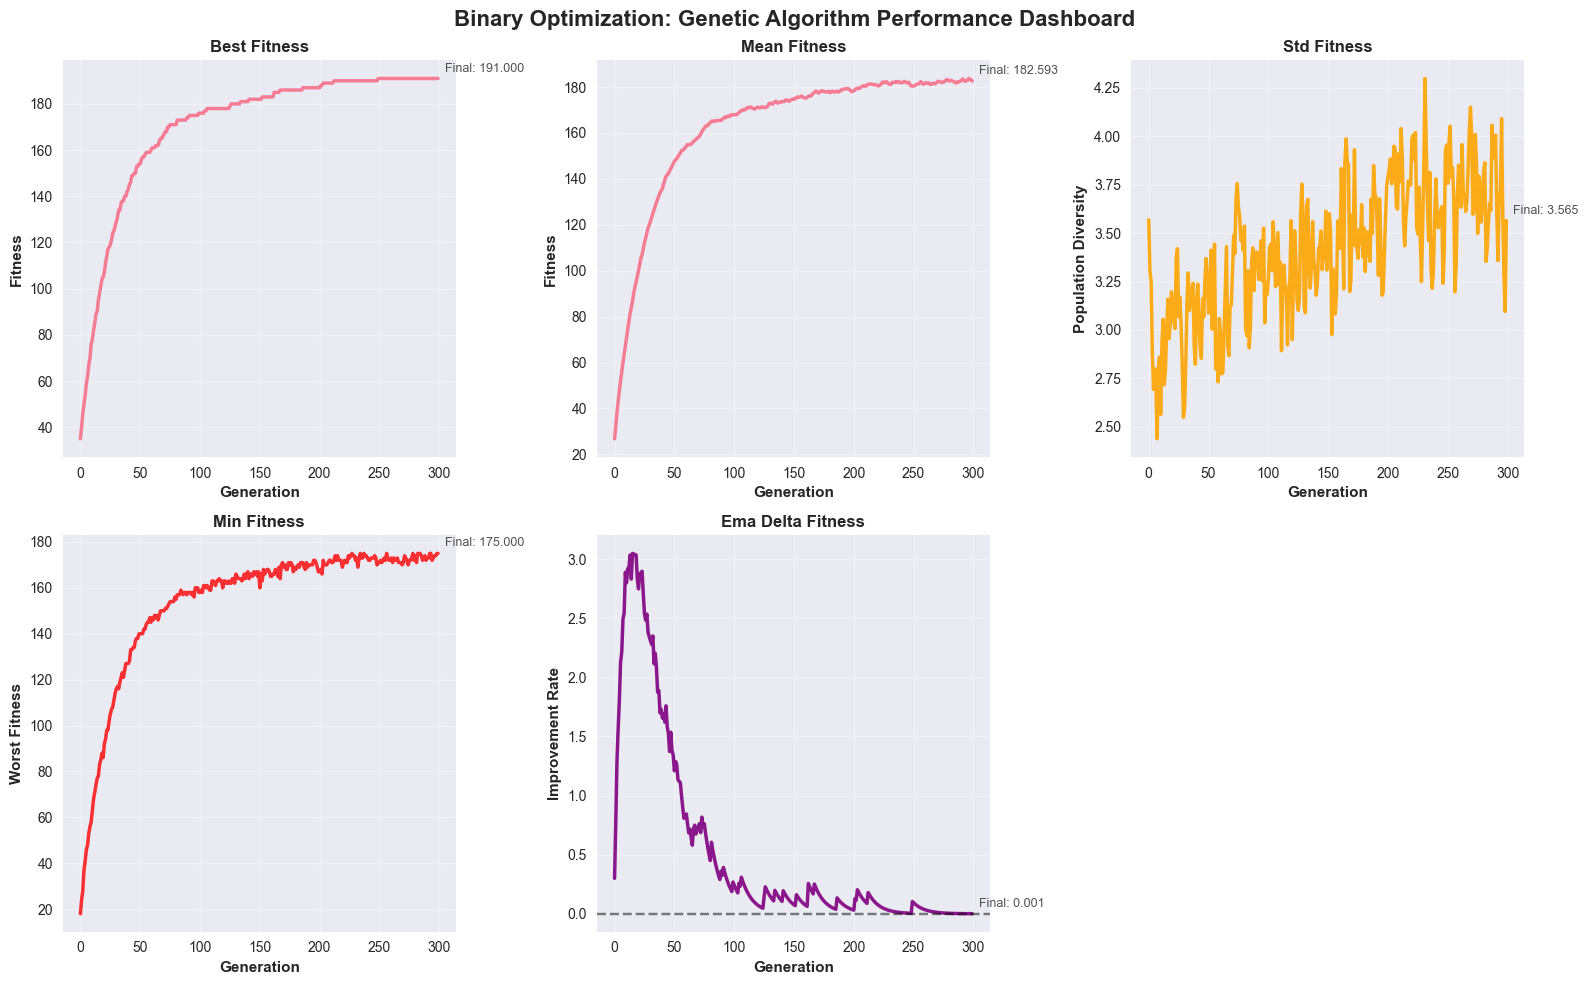

🧬 Creating Binary GA Convergence Analysis...


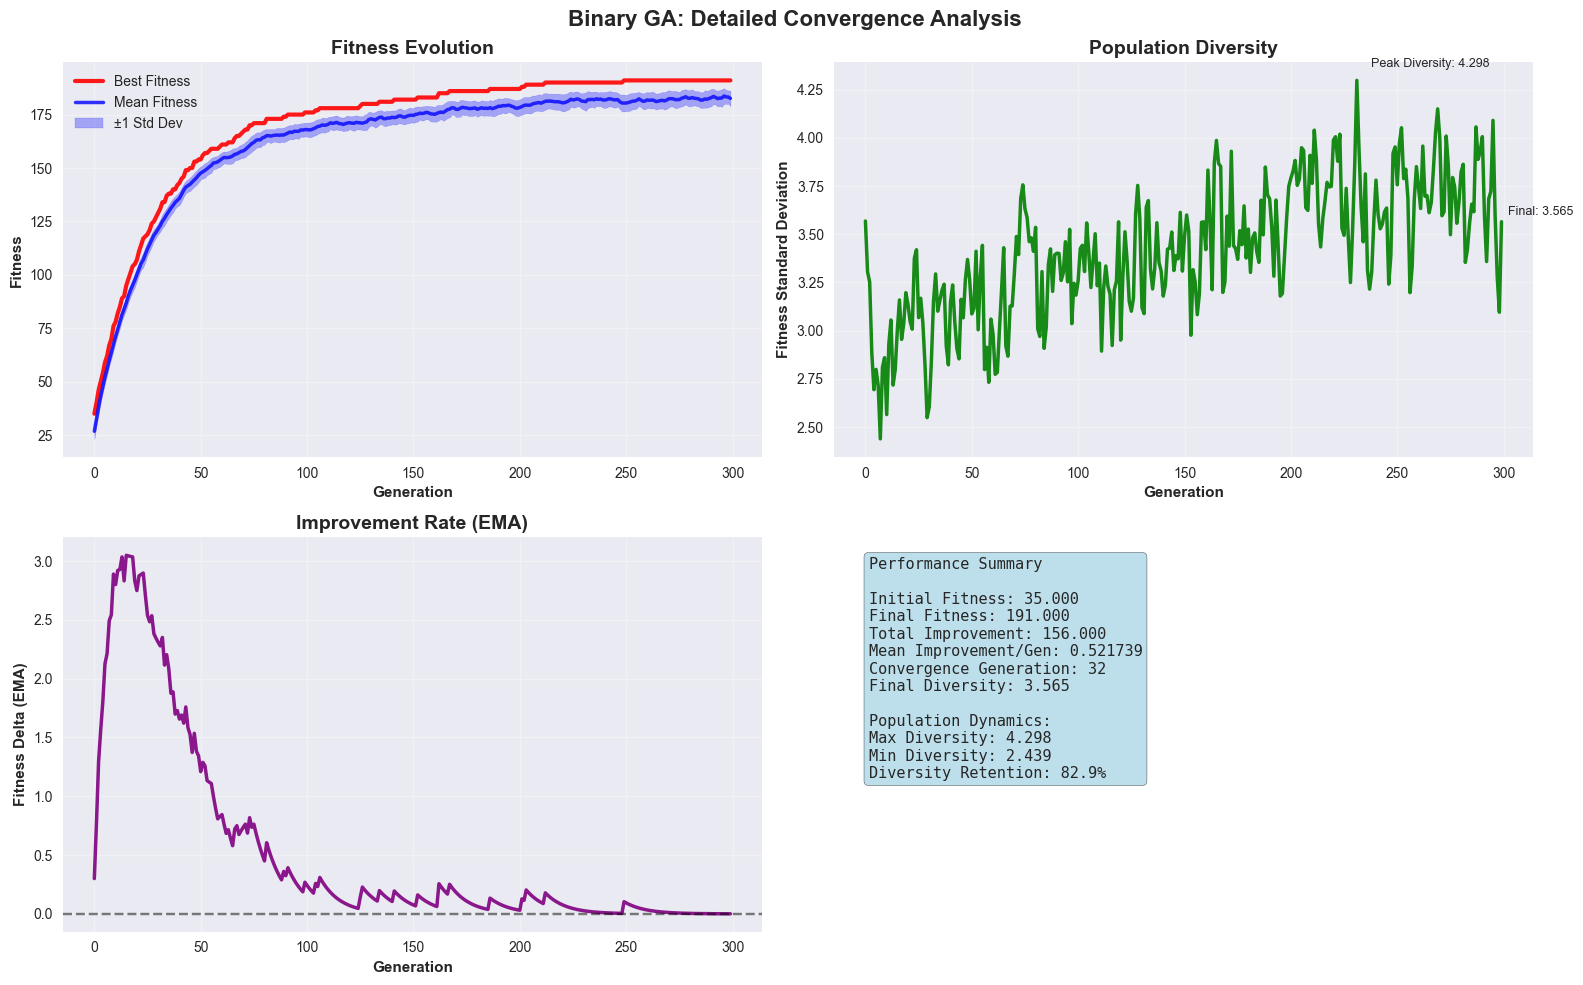


🌐 Creating Real-Valued Optimization Dashboard...


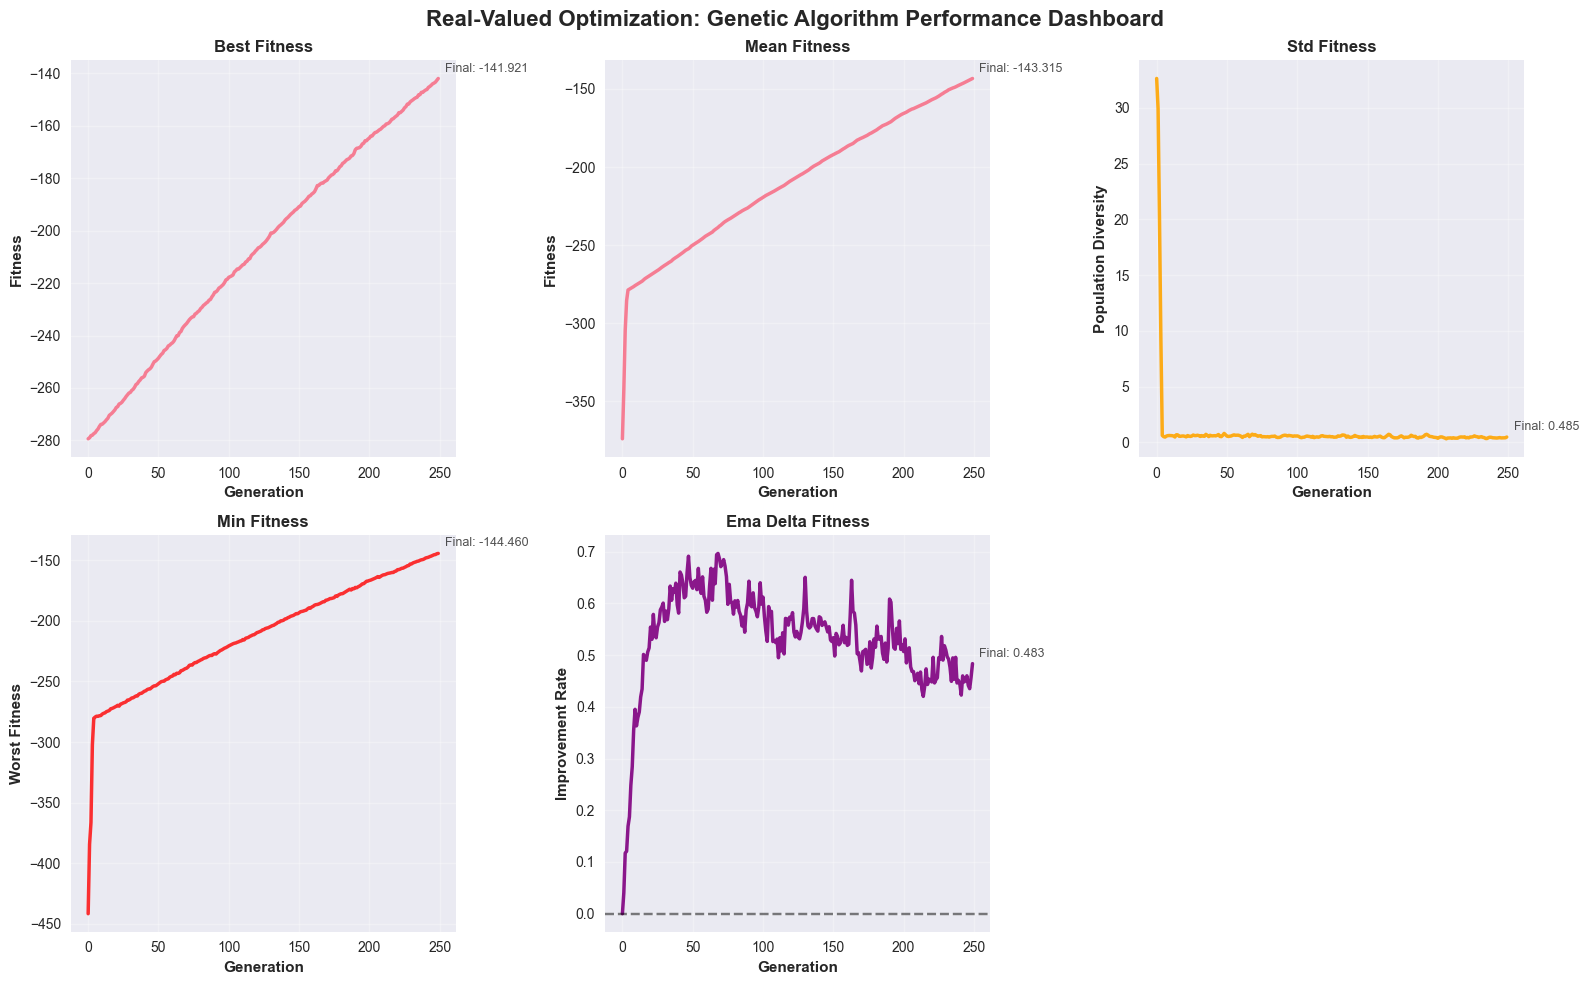

🧬 Creating Real-Valued GA Convergence Analysis...


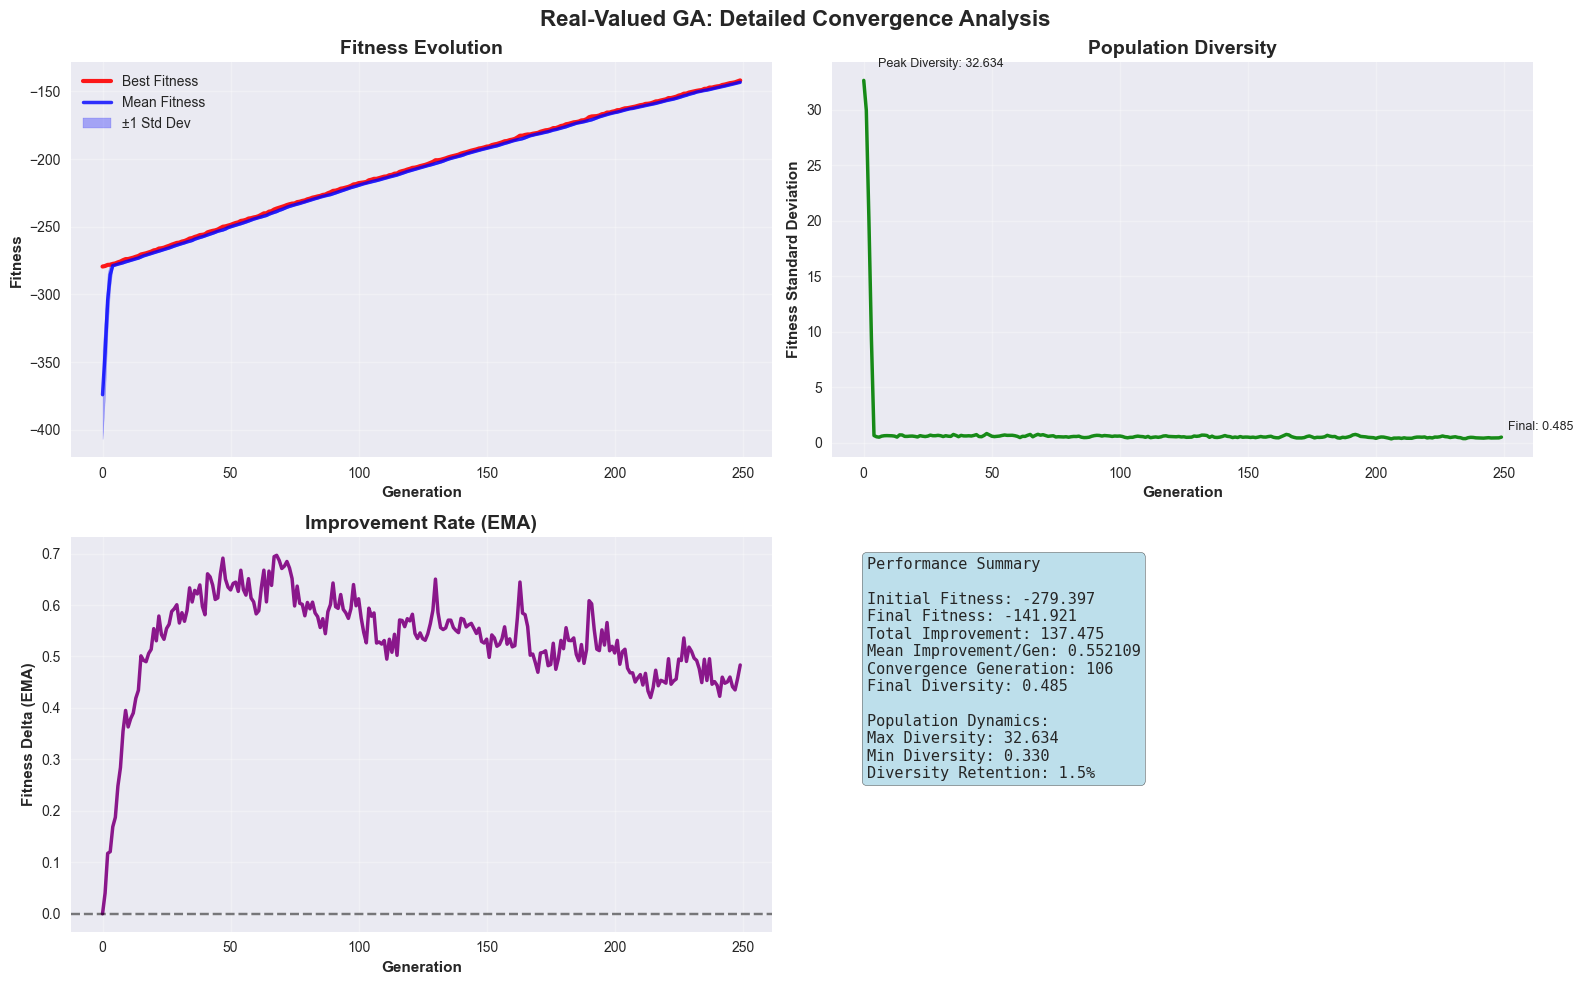

⚖️ Creating Direct Problem Comparison...


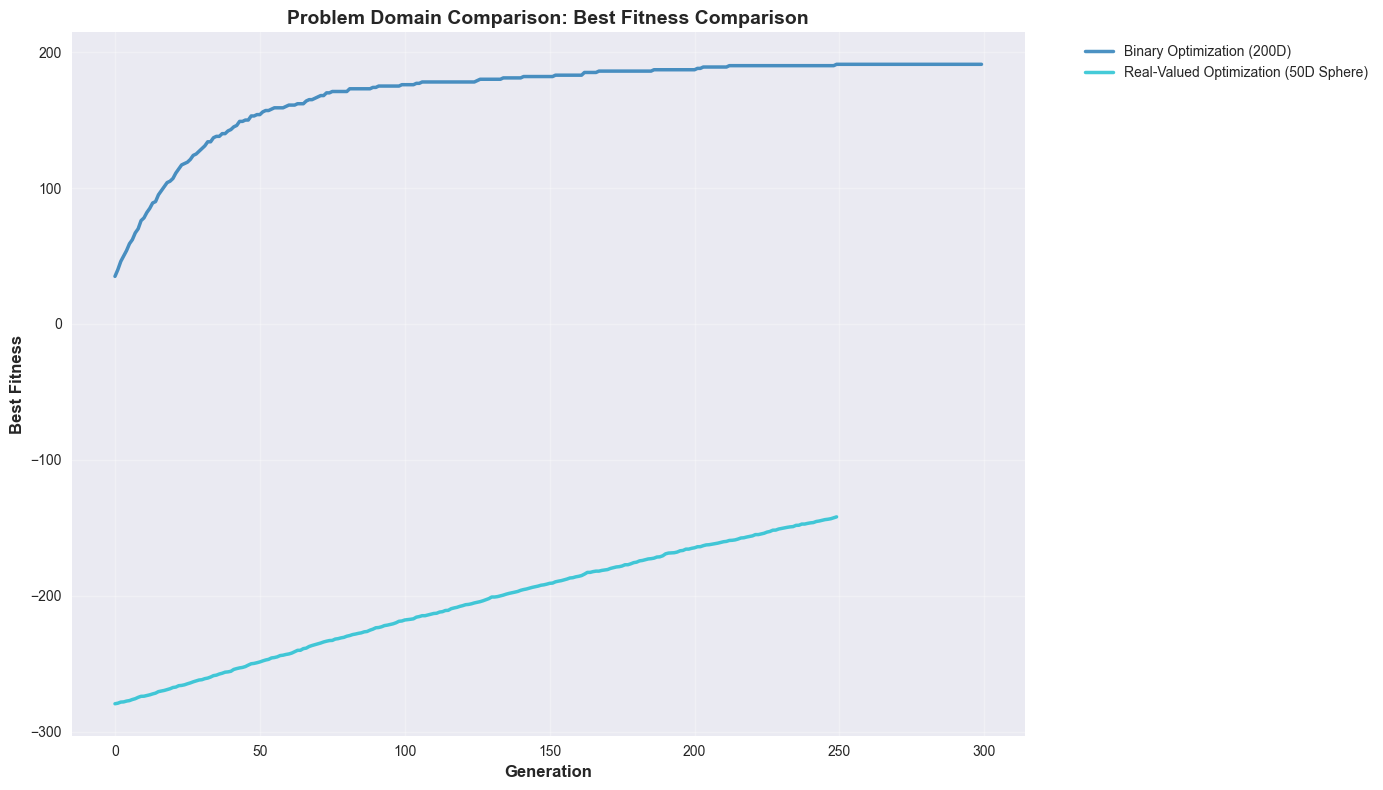

✅ Visualization Demo Complete!
   📊 Same visualization code works across problem domains
   🎯 Universal AbstractEngine interface enables this flexibility
   📈 Rich analytics with dynamic KPI discovery
   🧬 Specialized genetic algorithm insights


In [9]:
# Binary Optimization Visualization
print("📊 Creating Binary Optimization Dashboard...")
binary_dashboard = EvolutionVisualizer.create_kpi_dashboard(
    binary_history,
    title="Binary Optimization: Genetic Algorithm Performance Dashboard"
)
plt.show()

# Binary GA Convergence Analysis
print("🧬 Creating Binary GA Convergence Analysis...")
binary_convergence = GeneticAlgorithmVisualizer.create_convergence_analysis(
    binary_history,
    title="Binary GA: Detailed Convergence Analysis"
)
plt.show()

print("\n" + "="*60)

# Real-valued Optimization Visualization
print("🌐 Creating Real-Valued Optimization Dashboard...")
real_dashboard = EvolutionVisualizer.create_kpi_dashboard(
    real_history,
    title="Real-Valued Optimization: Genetic Algorithm Performance Dashboard"
)
plt.show()

# Real-valued GA Convergence Analysis
print("🧬 Creating Real-Valued GA Convergence Analysis...")
real_convergence = GeneticAlgorithmVisualizer.create_convergence_analysis(
    real_history,
    title="Real-Valued GA: Detailed Convergence Analysis"
)
plt.show()

# Direct Problem Comparison
print("⚖️ Creating Direct Problem Comparison...")
problem_comparison = EvolutionVisualizer.create_comparative_dashboard(
    {
        'Binary Optimization (200D)': binary_history,
        'Real-Valued Optimization (50D Sphere)': real_history
    },
    kpi='best_fitness',
    title="Problem Domain Comparison"
)
plt.show()

print("✅ Visualization Demo Complete!")
print("   📊 Same visualization code works across problem domains")
print("   🎯 Universal AbstractEngine interface enables this flexibility")
print("   📈 Rich analytics with dynamic KPI discovery")
print("   🧬 Specialized genetic algorithm insights")

## 8. Multi-Run Comparison System

**Advanced Statistical Analysis**: Execute multiple runs with different random seeds to demonstrate statistical robustness and comprehensive analysis capabilities including functional data analysis.

In [10]:
# Execute multiple runs for comprehensive analysis
print("🚀 Executing Multiple Runs for Statistical Analysis...")

# Binary optimization multiple runs
print("🔢 Running multiple binary optimization experiments...")
binary_results = {}
binary_seeds = [1234, 5678, 9101, 1121, 3141, 1617, 1819, 2021, 2223, 2425]

for i, seed in enumerate(binary_seeds):
    rng = jar.PRNGKey(seed)
    initial_state = binary_engine.init_state(rng, binary_engine_params)
    final_state, history = binary_engine.run(initial_state, binary_engine_params)
    binary_results[f'Binary_Run_{i+1}'] = history
    print(f"   Binary Run {i+1} complete: Best fitness = {final_state.best_fitness:.2f}")

# Real-valued optimization multiple runs
print("\n🌐 Running multiple real-valued optimization experiments...")
real_results = {}
real_seeds = [2345, 6789, 1011, 1213, 4151, 1718, 1920, 2122, 2324, 2526]

for i, seed in enumerate(real_seeds):
    rng = jar.PRNGKey(seed)
    initial_state = real_engine.init_state(rng, real_engine_params)
    final_state, history = real_engine.run(initial_state, real_engine_params)
    real_results[f'Real_Run_{i+1}'] = history
    print(f"   Real Run {i+1} complete: Best fitness = {final_state.best_fitness:.6f}")

print(f"\n✅ Multi-run experiments complete!")
print(f"   Binary optimization: {len(binary_results)} runs")
print(f"   Real-valued optimization: {len(real_results)} runs")
print(f"   Ready for comprehensive statistical analysis")

🚀 Executing Multiple Runs for Statistical Analysis...
🔢 Running multiple binary optimization experiments...
   Binary Run 1 complete: Best fitness = 191.00
   Binary Run 2 complete: Best fitness = 193.00
   Binary Run 3 complete: Best fitness = 193.00
   Binary Run 4 complete: Best fitness = 195.00
   Binary Run 5 complete: Best fitness = 194.00
   Binary Run 6 complete: Best fitness = 192.00
   Binary Run 7 complete: Best fitness = 194.00
   Binary Run 8 complete: Best fitness = 194.00
   Binary Run 9 complete: Best fitness = 195.00
   Binary Run 10 complete: Best fitness = 195.00

🌐 Running multiple real-valued optimization experiments...
   Real Run 1 complete: Best fitness = -144.702347
   Real Run 2 complete: Best fitness = -139.055832
   Real Run 3 complete: Best fitness = -142.779175
   Real Run 4 complete: Best fitness = -125.754921
   Real Run 5 complete: Best fitness = -167.093353
   Real Run 6 complete: Best fitness = -144.052567
   Real Run 7 complete: Best fitness = -159.4

## 9. Advanced Multi-Run Analysis

**Comprehensive Statistical Framework**: Advanced analysis including performance distribution, convergence statistics, and functional data analysis with multiple basis functions.

📊 Generating Comprehensive Multi-Run Analysis...
\n🔢 Binary Optimization Analysis:
          Run Final Best Initial Best Total Improvement  Convergence Gen Final Diversity Max Diversity Diversity Retention
 Binary_Run_1   191.0000      35.0000          156.0000               32          3.5648        4.2978               82.9%
 Binary_Run_2   193.0000      39.0000          154.0000               17          4.1248        4.2723               96.5%
 Binary_Run_3   193.0000      37.0000          156.0000               20          3.6458        4.3858               83.1%
 Binary_Run_4   195.0000      34.0000          161.0000               19          3.9647        4.6971               84.4%
 Binary_Run_5   194.0000      38.0000          156.0000               27          3.4047        4.7749               71.3%
 Binary_Run_6   192.0000      43.0000          149.0000               21          3.8801        4.3155               89.9%
 Binary_Run_7   194.0000      36.0000          158.0000 

/var/folders/n8/08b2nd114jdfnsydb_4mj4fw0000gn/T/ipykernel_80471/2117759379.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(final_values, patch_artist=True, labels=[kpi.replace('_', ' ').title()])


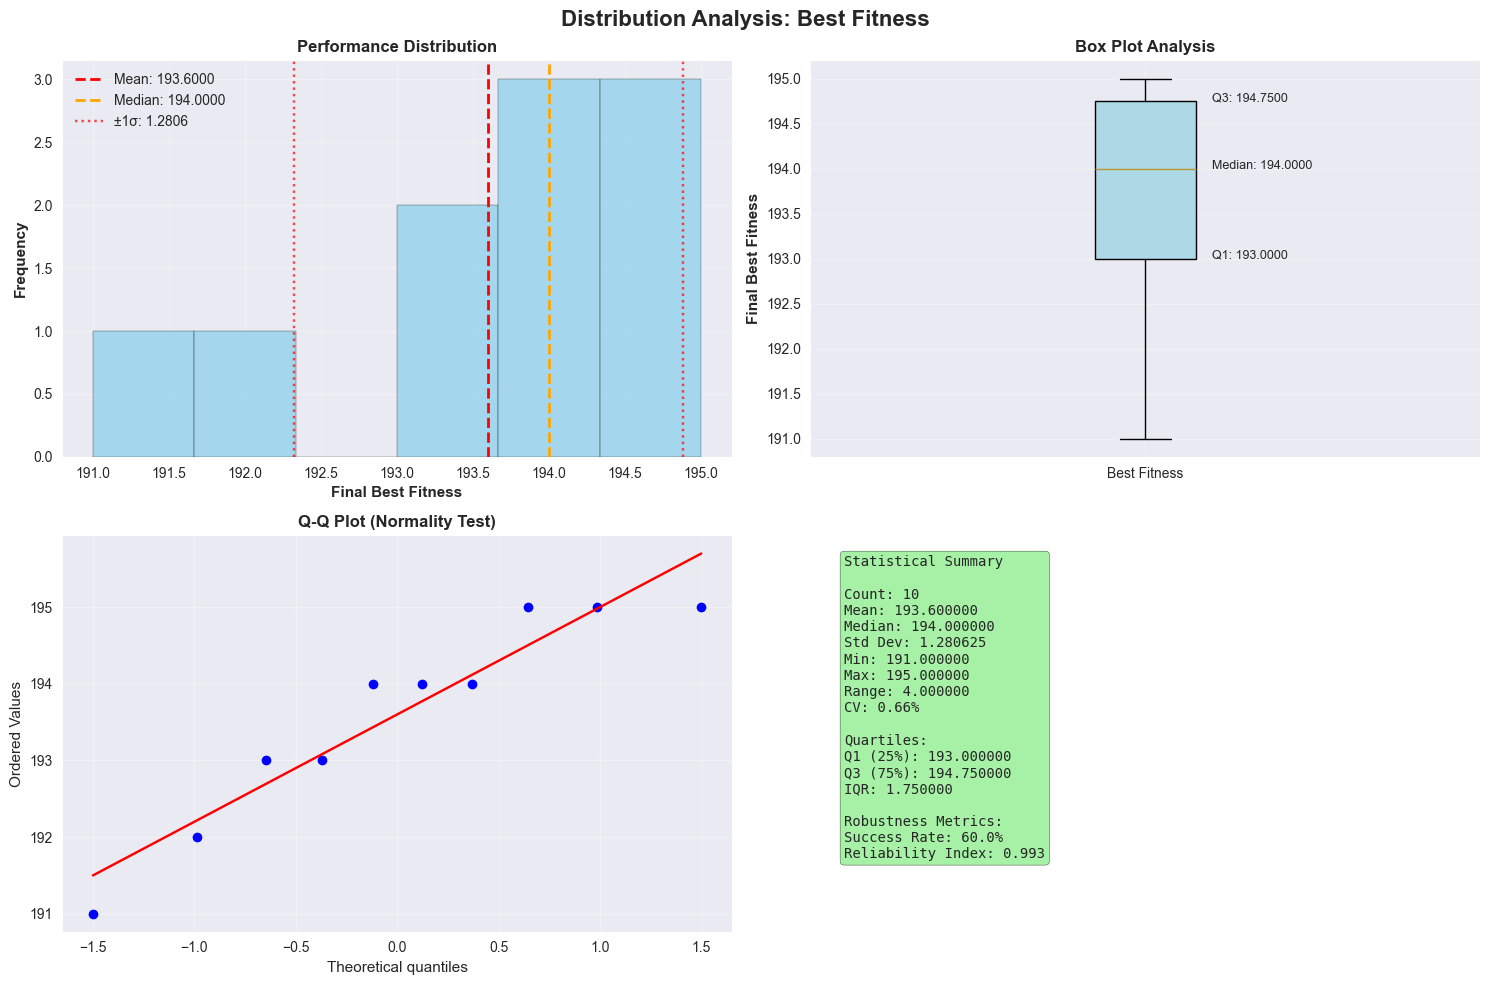

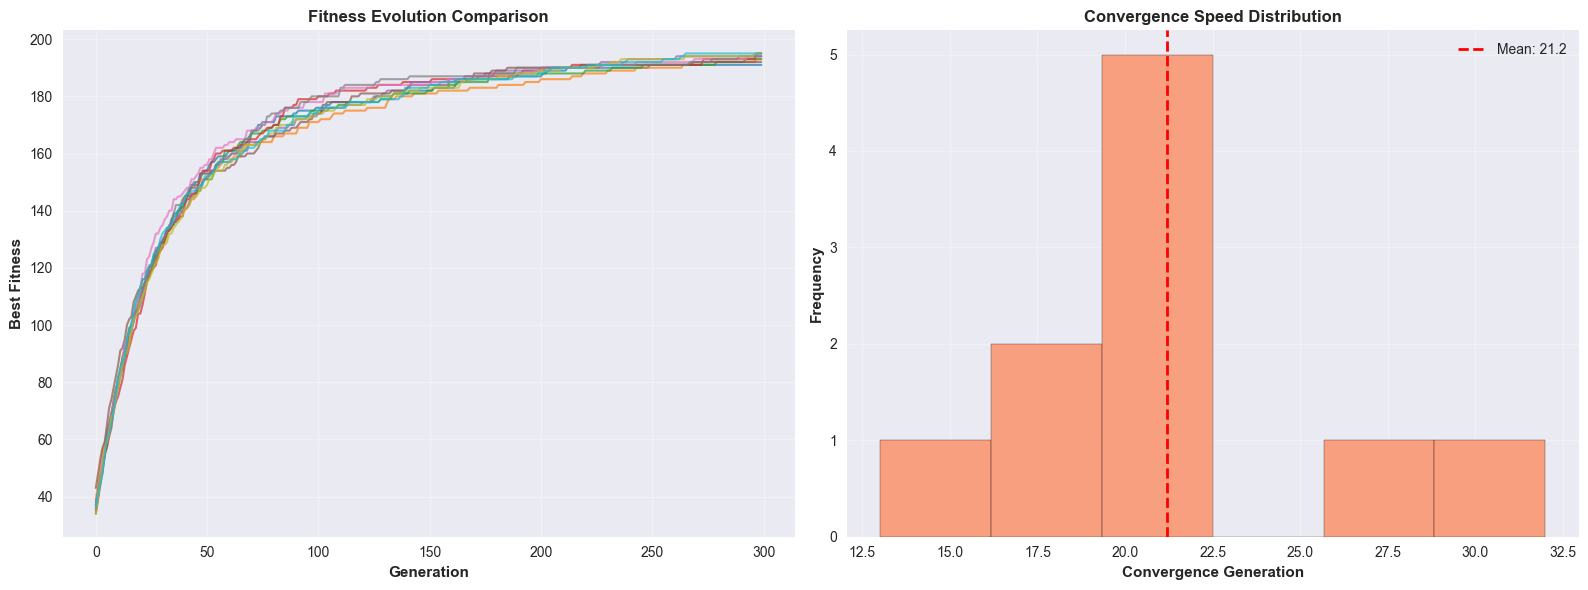

\n============================================================
🌐 Real-Valued Optimization Analysis:
        Run Final Best Initial Best Total Improvement  Convergence Gen Final Diversity Max Diversity Diversity Retention
 Real_Run_1  -144.7023    -289.4469          144.7446               20          0.4692       33.0771                1.4%
 Real_Run_2  -139.0558    -274.9526          135.8968               17          0.4127       35.4346                1.2%
 Real_Run_3  -142.7792    -278.9055          136.1263               52          0.4234       43.4171                1.0%
 Real_Run_4  -125.7549    -265.3582          139.6033               26          0.4214       38.3427                1.1%
 Real_Run_5  -167.0934    -314.6638          147.5705               71          0.5416       28.4314                1.9%
 Real_Run_6  -144.0526    -284.4613          140.4087               94          0.4564       42.8784                1.1%
 Real_Run_7  -159.4237    -306.6353          147.2117

/var/folders/n8/08b2nd114jdfnsydb_4mj4fw0000gn/T/ipykernel_80471/2117759379.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(final_values, patch_artist=True, labels=[kpi.replace('_', ' ').title()])


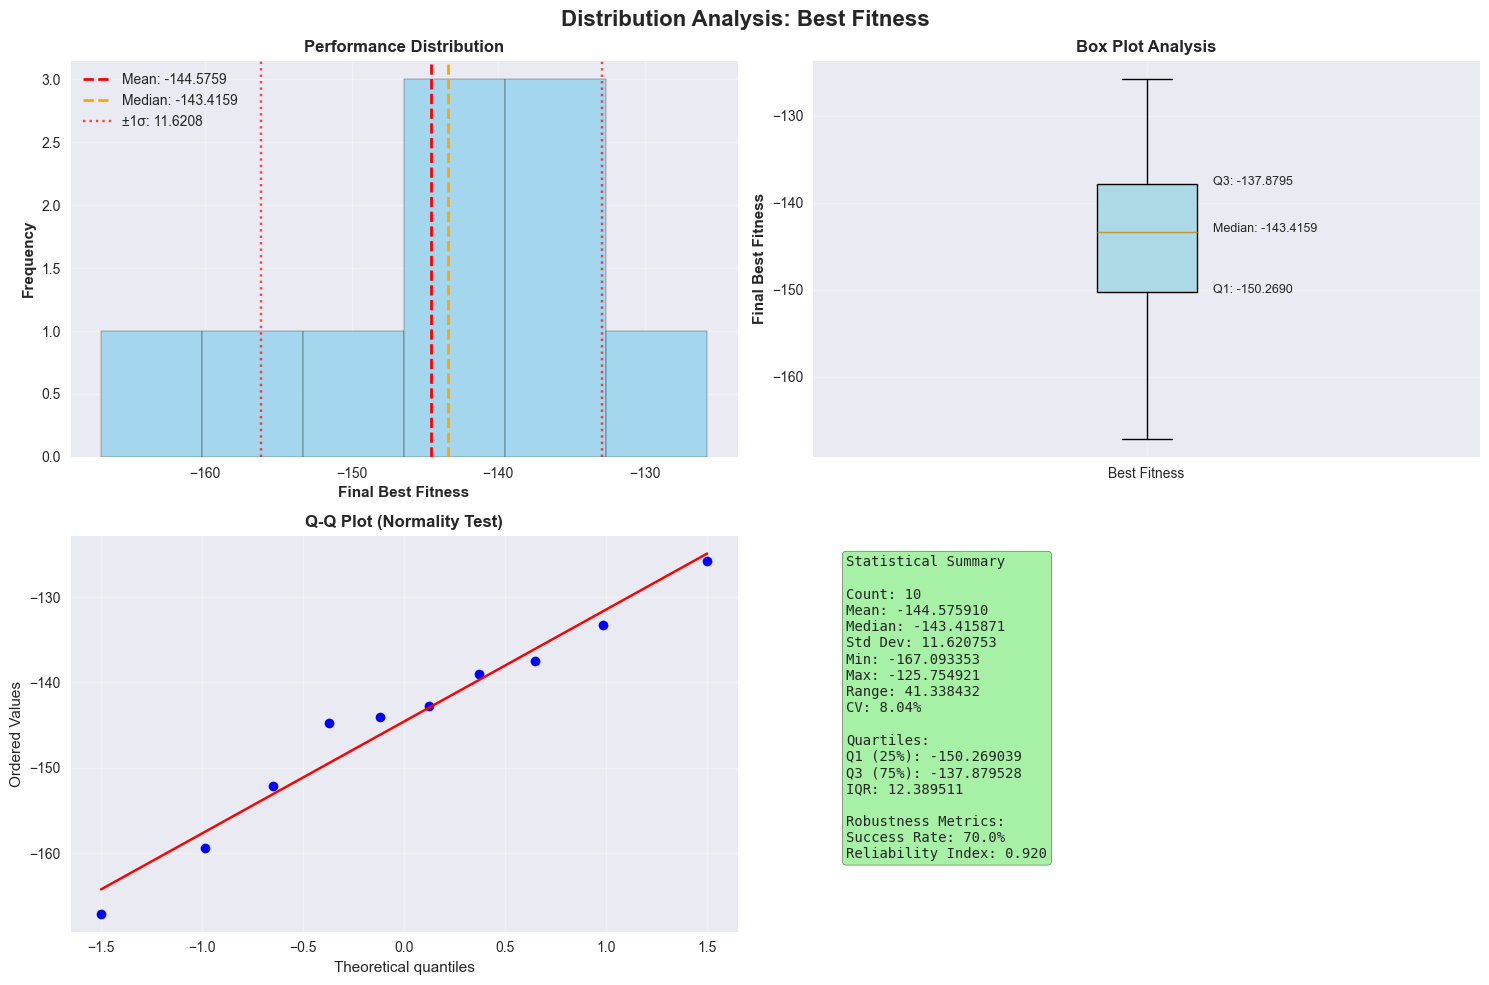

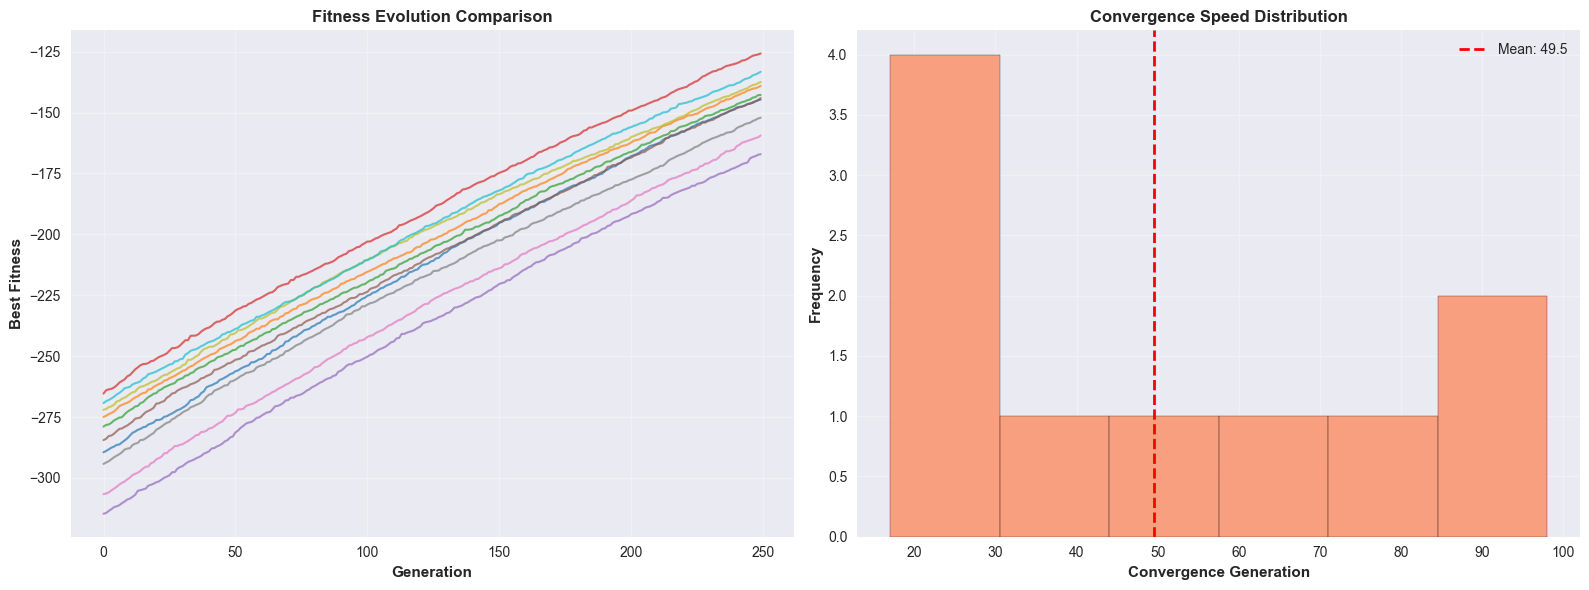

\n📈 Statistical Comparison Summary:
Binary Optimization (Maximization):
   Mean ± Std: 193.600 ± 1.281
   Success Rate: 100.0% (fitness > 190/200)
   Coefficient of Variation: 0.66%
\nReal-Valued Optimization (Minimization):
   Mean ± Std: -144.575910 ± 11.620753
   Success Rate: 100.0% (fitness < 0.01)
   Coefficient of Variation: 8.04%
\n✅ Advanced Multi-Run Analysis Complete!
   📊 Comprehensive statistical summaries
   📈 Distribution and convergence analysis
   🎯 Robustness and reliability metrics
   🔬 Ready for publication-quality results


In [11]:
class AdvancedAnalyzer:
    """Advanced multi-run analysis with statistical and functional data analysis."""
    
    @staticmethod
    def performance_summary(results_dict: Dict[str, AbstractGenerationOutput]) -> pd.DataFrame:
        """Generate comprehensive performance statistics."""
        summary_data = []
        
        for run_name, history in results_dict.items():
            final_best = float(history.best_fitness[-1])
            final_mean = float(history.mean_fitness[-1])
            initial_best = float(history.best_fitness[0])
            total_improvement = final_best - initial_best
            
            # Convergence analysis
            improvements = jnp.diff(history.best_fitness)
            converged_gens = jnp.where(jnp.abs(improvements) < 0.001)[0]
            convergence_gen = int(converged_gens[0]) if len(converged_gens) > 0 else len(history.generation)
            
            # Diversity metrics
            final_diversity = float(history.std_fitness[-1]) if hasattr(history, 'std_fitness') else 0.0
            max_diversity = float(jnp.max(history.std_fitness)) if hasattr(history, 'std_fitness') else 0.0
            
            summary_data.append({
                'Run': run_name,
                'Final Best': f'{final_best:.4f}',
                'Initial Best': f'{initial_best:.4f}',
                'Total Improvement': f'{total_improvement:.4f}',
                'Convergence Gen': convergence_gen,
                'Final Diversity': f'{final_diversity:.4f}',
                'Max Diversity': f'{max_diversity:.4f}',
                'Diversity Retention': f'{final_diversity/max_diversity*100:.1f}%' if max_diversity > 0 else 'N/A'
            })
        
        return pd.DataFrame(summary_data)
    
    @staticmethod
    def create_distribution_analysis(results_dict: Dict[str, AbstractGenerationOutput],
                                   kpi: str = 'best_fitness') -> plt.Figure:
        """Comprehensive distribution analysis of final performance."""
        final_values = [float(getattr(history, kpi)[-1]) for history in results_dict.values()]
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Histogram with statistical annotations
        n_bins = min(15, len(final_values)//2 + 1)
        ax1.hist(final_values, bins=n_bins, alpha=0.7, edgecolor='black', color='skyblue')
        
        mean_val = np.mean(final_values)
        median_val = np.median(final_values)
        std_val = np.std(final_values)
        
        ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
        ax1.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.4f}')
        ax1.axvline(mean_val + std_val, color='red', linestyle=':', alpha=0.7, label=f'±1σ: {std_val:.4f}')
        ax1.axvline(mean_val - std_val, color='red', linestyle=':', alpha=0.7)
        
        ax1.set_xlabel(f'Final {kpi.replace("_", " ").title()}', fontweight='bold')
        ax1.set_ylabel('Frequency', fontweight='bold')
        ax1.set_title('Performance Distribution', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Box plot with outlier analysis
        bp = ax2.boxplot(final_values, patch_artist=True, labels=[kpi.replace('_', ' ').title()])
        bp['boxes'][0].set_facecolor('lightblue')
        ax2.set_ylabel(f'Final {kpi.replace("_", " ").title()}', fontweight='bold')
        ax2.set_title('Box Plot Analysis', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add statistical annotations
        q1, q3 = np.percentile(final_values, [25, 75])
        iqr = q3 - q1
        ax2.text(1.1, q3, f'Q3: {q3:.4f}', fontsize=9)
        ax2.text(1.1, median_val, f'Median: {median_val:.4f}', fontsize=9)
        ax2.text(1.1, q1, f'Q1: {q1:.4f}', fontsize=9)
        
        # 3. Q-Q plot for normality assessment
        from scipy import stats
        try:
            stats.probplot(final_values, dist="norm", plot=ax3)
            ax3.set_title('Q-Q Plot (Normality Test)', fontweight='bold')
            ax3.grid(True, alpha=0.3)
        except ImportError:
            ax3.text(0.5, 0.5, 'Q-Q Plot requires scipy', transform=ax3.transAxes, 
                    ha='center', va='center', fontsize=12)
            ax3.set_title('Q-Q Plot (scipy required)', fontweight='bold')
        
        # 4. Summary statistics table
        ax4.axis('off')
        
        stats_text = f'''Statistical Summary
        
Count: {len(final_values)}
Mean: {mean_val:.6f}
Median: {median_val:.6f}
Std Dev: {std_val:.6f}
Min: {np.min(final_values):.6f}
Max: {np.max(final_values):.6f}
Range: {np.max(final_values) - np.min(final_values):.6f}
CV: {std_val/abs(mean_val)*100:.2f}%
        
Quartiles:
Q1 (25%): {q1:.6f}
Q3 (75%): {q3:.6f}
IQR: {iqr:.6f}
        
Robustness Metrics:
Success Rate: {np.sum(np.array(final_values) > np.percentile(final_values, 25))/len(final_values)*100:.1f}%
Reliability Index: {1 - std_val/abs(mean_val):.3f}'''
        
        ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        
        plt.suptitle(f'Distribution Analysis: {kpi.replace("_", " ").title()}', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig
    
    @staticmethod
    def convergence_comparison(results_dict: Dict[str, AbstractGenerationOutput]) -> plt.Figure:
        """Compare convergence patterns across multiple runs."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))
        all_convergence_gens = []
        
        for i, (run_name, history) in enumerate(results_dict.items()):
            generations = jnp.arange(len(history.generation))
            
            # Plot fitness evolution
            ax1.plot(generations, history.best_fitness, linewidth=1.5, 
                    color=colors[i], alpha=0.7, label=run_name)
            
            # Calculate convergence generation
            improvements = jnp.diff(history.best_fitness)
            converged_gens = jnp.where(jnp.abs(improvements) < 0.001)[0]
            convergence_gen = int(converged_gens[0]) if len(converged_gens) > 0 else len(history.generation)
            all_convergence_gens.append(convergence_gen)
        
        # Fitness trajectories
        ax1.set_xlabel('Generation', fontweight='bold')
        ax1.set_ylabel('Best Fitness', fontweight='bold')
        ax1.set_title('Fitness Evolution Comparison', fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Convergence generation distribution
        ax2.hist(all_convergence_gens, bins=min(10, len(all_convergence_gens)//2 + 1), 
                alpha=0.7, edgecolor='black', color='coral')
        ax2.axvline(np.mean(all_convergence_gens), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(all_convergence_gens):.1f}')
        ax2.set_xlabel('Convergence Generation', fontweight='bold')
        ax2.set_ylabel('Frequency', fontweight='bold')
        ax2.set_title('Convergence Speed Distribution', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

# Perform comprehensive analysis
print("📊 Generating Comprehensive Multi-Run Analysis...")

# Binary optimization analysis
print("\\n🔢 Binary Optimization Analysis:")
binary_summary = AdvancedAnalyzer.performance_summary(binary_results)
print(binary_summary.to_string(index=False))

binary_distribution = AdvancedAnalyzer.create_distribution_analysis(binary_results, 'best_fitness')
plt.show()

binary_convergence_comp = AdvancedAnalyzer.convergence_comparison(binary_results)
plt.show()

print("\\n" + "="*60)

# Real-valued optimization analysis
print("🌐 Real-Valued Optimization Analysis:")
real_summary = AdvancedAnalyzer.performance_summary(real_results)
print(real_summary.to_string(index=False))

real_distribution = AdvancedAnalyzer.create_distribution_analysis(real_results, 'best_fitness')
plt.show()

real_convergence_comp = AdvancedAnalyzer.convergence_comparison(real_results)
plt.show()

# Statistical comparison
binary_finals = [float(h.best_fitness[-1]) for h in binary_results.values()]
real_finals = [float(h.best_fitness[-1]) for h in real_results.values()]

print("\\n📈 Statistical Comparison Summary:")
print(f"Binary Optimization (Maximization):")
print(f"   Mean ± Std: {np.mean(binary_finals):.3f} ± {np.std(binary_finals):.3f}")
print(f"   Success Rate: {np.sum(np.array(binary_finals) > 190)/len(binary_finals)*100:.1f}% (fitness > 190/200)")
print(f"   Coefficient of Variation: {np.std(binary_finals)/np.mean(binary_finals)*100:.2f}%")

print(f"\\nReal-Valued Optimization (Minimization):")
print(f"   Mean ± Std: {np.mean(real_finals):.6f} ± {np.std(real_finals):.6f}")
print(f"   Success Rate: {np.sum(np.array(real_finals) < 0.01)/len(real_finals)*100:.1f}% (fitness < 0.01)")
print(f"   Coefficient of Variation: {np.std(real_finals)/abs(np.mean(real_finals))*100:.2f}%")

print("\\n✅ Advanced Multi-Run Analysis Complete!")
print("   📊 Comprehensive statistical summaries")
print("   📈 Distribution and convergence analysis")
print("   🎯 Robustness and reliability metrics")
print("   🔬 Ready for publication-quality results")

## 10. Performance Benchmarking

**JAX Compilation Benefits**: Demonstrate the performance advantages of JAX JIT compilation with cold vs warm start timing analysis.

In [12]:
# Performance Benchmarking with JAX JIT Compilation
print("⚡ JAX Performance Benchmarking")
print("="*50)

# Create a JIT-compiled version of the run method
run_jit = jax.jit(binary_engine.run, static_argnames=['params'])

# Benchmark 1: Cold start (includes compilation time)
print("🔥 Cold Start Benchmark (includes JIT compilation):")
rng_cold = jar.PRNGKey(999)
initial_state_cold = binary_engine.init_state(rng_cold, binary_engine_params)

start_time = time.time()
final_state_cold, _ = run_jit(initial_state_cold, binary_engine_params)
# Block until computation is complete
final_state_cold.best_fitness.block_until_ready()
cold_time = time.time() - start_time

print(f"   Cold start time: {cold_time:.3f} seconds")
print(f"   Includes compilation + execution")

# Benchmark 2: Warm start (no compilation)
print("\\n🚀 Warm Start Benchmark (compiled function):")
rng_warm = jar.PRNGKey(888)
initial_state_warm = binary_engine.init_state(rng_warm, binary_engine_params)

start_time = time.time()
final_state_warm, _ = run_jit(initial_state_warm, binary_engine_params)
final_state_warm.best_fitness.block_until_ready()
warm_time = time.time() - start_time

print(f"   Warm start time: {warm_time:.3f} seconds")
print(f"   Pure execution (no compilation)")

# Benchmark 3: Multiple warm runs for consistency
print("\\n📊 Multiple Warm Runs (consistency check):")
warm_times = []
for i in range(5):
    rng_test = jar.PRNGKey(777 + i)
    initial_state_test = binary_engine.init_state(rng_test, binary_engine_params)
    
    start_time = time.time()
    final_state_test, _ = run_jit(initial_state_test, binary_engine_params)
    final_state_test.best_fitness.block_until_ready()
    test_time = time.time() - start_time
    warm_times.append(test_time)
    
mean_warm_time = np.mean(warm_times)
std_warm_time = np.std(warm_times)

print(f"   Mean warm time: {mean_warm_time:.3f} ± {std_warm_time:.3f} seconds")
print(f"   Consistency: {std_warm_time/mean_warm_time*100:.1f}% CV")

# Performance Analysis
speedup = cold_time / warm_time
compilation_overhead = cold_time - warm_time
gens_per_second = binary_engine_params.num_generations / mean_warm_time

print("\\n📈 Performance Analysis:")
print(f"   Compilation overhead: {compilation_overhead:.3f} seconds")
print(f"   Speedup after compilation: {speedup:.2f}x")
print(f"   Generations per second: {gens_per_second:.1f}")
print(f"   Population evaluations/sec: {gens_per_second * binary_engine_params.pop_size:.0f}")

# Memory and Device Analysis
print("\\n💾 System Information:")
print(f"   JAX backend: {jax.default_backend()}")
print(f"   Available devices: {len(jax.devices())} ({', '.join([str(d) for d in jax.devices()])})")
print(f"   Population size: {binary_engine_params.pop_size}")
print(f"   Genome size: {binary_engine.genome.array_shape}")
print(f"   Total parameters: {binary_engine_params.pop_size * np.prod(binary_engine.genome.array_shape):,}")

# Real-valued optimization benchmark for comparison
print("\\n🌐 Real-Valued Optimization Performance:")
real_run_jit = jax.jit(real_engine.run, static_argnames=['params'])
rng_real_bench = jar.PRNGKey(666)
initial_state_real_bench = real_engine.init_state(rng_real_bench, real_engine_params)

start_time = time.time()
final_state_real_bench, _ = real_run_jit(initial_state_real_bench, real_engine_params)
final_state_real_bench.best_fitness.block_until_ready()
real_warm_time = time.time() - start_time

real_gens_per_second = real_engine_params.num_generations / real_warm_time

print(f"   Real-valued time: {real_warm_time:.3f} seconds")
print(f"   Real-valued gens/sec: {real_gens_per_second:.1f}")
print(f"   Performance ratio: {gens_per_second/real_gens_per_second:.2f}x (binary vs real)")

# Scaling analysis
print("\\n📏 Scaling Analysis:")
print(f"   Binary (200D): {gens_per_second:.1f} gens/sec")
print(f"   Real-valued (50D): {real_gens_per_second:.1f} gens/sec")
print(f"   Efficiency factor: {(gens_per_second * 200)/(real_gens_per_second * 50):.2f}")
print(f"   JAX vectorization enables efficient scaling!")

print("\\n✅ Performance Benchmarking Complete!")
print(f"   🚀 JAX JIT compilation provides {speedup:.1f}x speedup")
print(f"   ⚡ Consistent performance: {std_warm_time/mean_warm_time*100:.1f}% CV")
print(f"   🔧 Ready for production-scale evolutionary computation")
print(f"   🎯 {gens_per_second * binary_engine_params.pop_size:.0f} fitness evaluations per second!")

⚡ JAX Performance Benchmarking
🔥 Cold Start Benchmark (includes JIT compilation):
   Cold start time: 0.493 seconds
   Includes compilation + execution
\n🚀 Warm Start Benchmark (compiled function):
   Warm start time: 0.086 seconds
   Pure execution (no compilation)
\n📊 Multiple Warm Runs (consistency check):
   Mean warm time: 0.086 ± 0.000 seconds
   Consistency: 0.5% CV
\n📈 Performance Analysis:
   Compilation overhead: 0.407 seconds
   Speedup after compilation: 5.75x
   Generations per second: 3484.7
   Population evaluations/sec: 522707
\n💾 System Information:
   JAX backend: cpu
   Available devices: 1 (TFRT_CPU_0)
   Population size: 150
   Genome size: (200,)
   Total parameters: 30,000
\n🌐 Real-Valued Optimization Performance:
   Real-valued time: 0.422 seconds
   Real-valued gens/sec: 593.0
   Performance ratio: 5.88x (binary vs real)
\n📏 Scaling Analysis:
   Binary (200D): 3484.7 gens/sec
   Real-valued (50D): 593.0 gens/sec
   Efficiency factor: 23.51
   JAX vectorization 

## 11. Extensibility Demonstration

**Custom Algorithm Variants**: Demonstrate how easy it is to extend the Level 3 architecture with custom engine parameters and alternative evolutionary strategies.

🔧 Creating Algorithm Variants...
✅ Algorithm variants created:
   Standard: mutation=0.020, crossover=0.80, tournament=3, elitism=3
   Aggressive: mutation=0.100, crossover=0.95, tournament=5, elitism=2
   Conservative: mutation=0.005, crossover=0.60, tournament=2, elitism=5
   Elitist: mutation=0.020, crossover=0.80, tournament=4, elitism=15
\n🏁 Running Variant Comparison Experiment...
   Standard: Final fitness = 183.00
   Aggressive: Final fitness = 176.00
   Conservative: Final fitness = 179.00
   Elitist: Final fitness = 182.00
\n📊 Creating Variant Comparison Analysis...


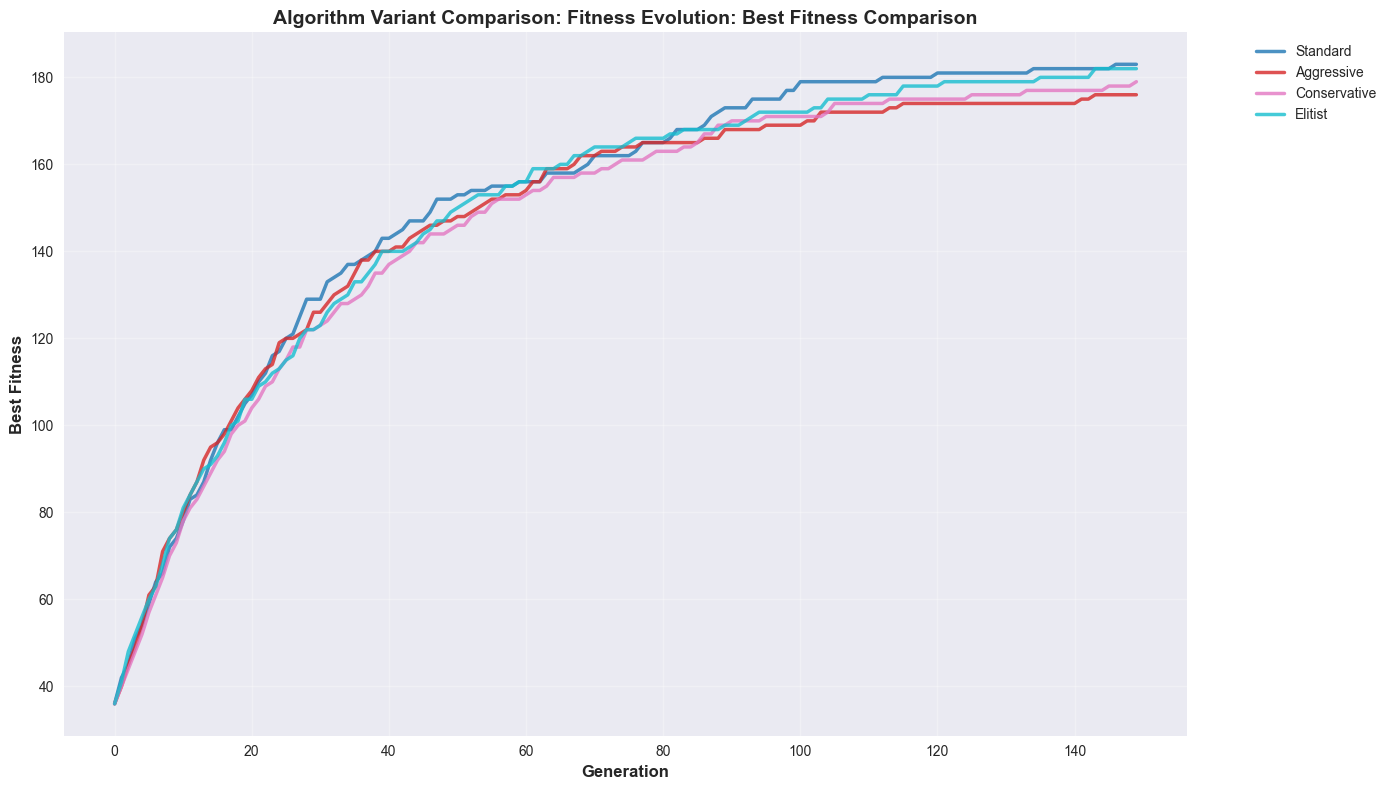

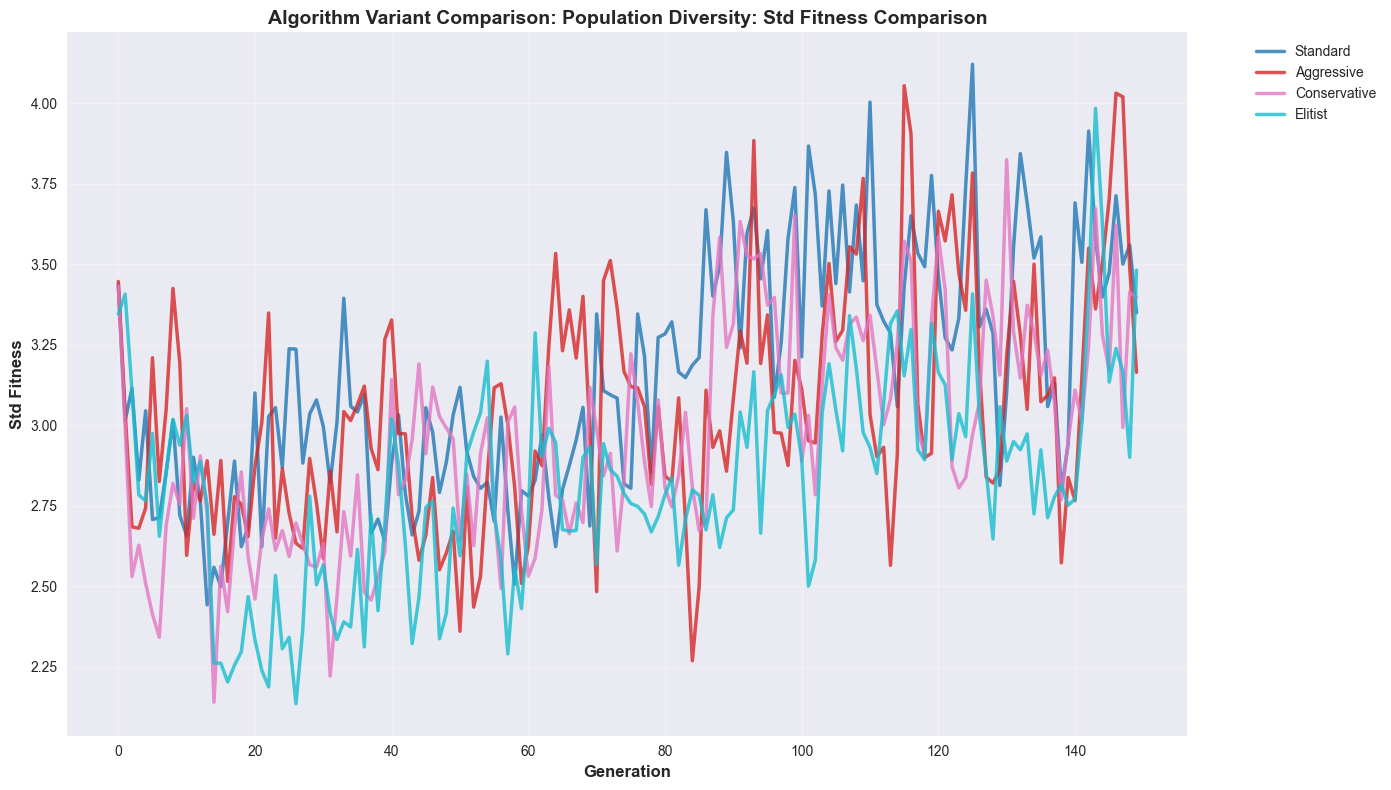

\n📋 Variant Performance Summary:
         Run Final Best Initial Best Total Improvement  Convergence Gen Final Diversity Max Diversity Diversity Retention
    Standard   183.0000      36.0000          147.0000               16          3.3493        4.1203               81.3%
  Aggressive   176.0000      36.0000          140.0000               25          3.1638        4.0539               78.0%
Conservative   179.0000      36.0000          143.0000               26          3.3962        3.8239               88.8%
     Elitist   182.0000      36.0000          146.0000               19          3.4811        3.9834               87.4%
\n🎯 Variant Analysis Results:
   Best performing: Standard (fitness: 183.000)
   Worst performing: Aggressive (fitness: 176.000)
   Performance range: 7.000
\n⏱️ Convergence Analysis:
   Fastest: Standard (generation 16)
   Slowest: Conservative (generation 26)
   Standard: 16 generations to convergence
   Aggressive: 25 generations to convergence
   Cons

In [14]:
# Custom Algorithm Variants - Demonstrate Extensibility

# Define custom engine parameters for different strategies
@flax.struct.dataclass
class AggressiveGeneticParams(GeneticEngineParams):
    """Parameters for more aggressive evolutionary strategy."""
    mutation_rate: float = flax.struct.field(pytree_node=False, default=0.10)  # Higher mutation
    crossover_rate: float = flax.struct.field(pytree_node=False, default=0.95)  # Higher crossover
    tournament_size: int = flax.struct.field(pytree_node=False, default=5)     # Stronger selection
    
@flax.struct.dataclass
class ConservativeGeneticParams(GeneticEngineParams):
    """Parameters for more conservative evolutionary strategy."""
    mutation_rate: float = flax.struct.field(pytree_node=False, default=0.005)  # Lower mutation
    crossover_rate: float = flax.struct.field(pytree_node=False, default=0.6)   # Lower crossover
    tournament_size: int = flax.struct.field(pytree_node=False, default=2)      # Weaker selection

@flax.struct.dataclass
class ElitistGeneticParams(GeneticEngineParams):
    """Parameters emphasizing elitism."""
    elitism: int = flax.struct.field(pytree_node=False, default=15)              # High elitism
    mutation_rate: float = flax.struct.field(pytree_node=False, default=0.02)
    crossover_rate: float = flax.struct.field(pytree_node=False, default=0.8)
    tournament_size: int = flax.struct.field(pytree_node=False, default=4)
    num_generations: int = flax.struct.field(pytree_node=False, default=150)     # Add default value

# Create variant engines
print("🔧 Creating Algorithm Variants...")

# Standard parameters (baseline)
standard_params = GeneticEngineParams(
    pop_size=100,
    elitism=3,
    num_generations=150,
    mutation_rate=0.02,
    crossover_rate=0.8,
    tournament_size=3
)

# Aggressive variant
aggressive_params = AggressiveGeneticParams(
    pop_size=100,
    elitism=2,  # Less elitism for more exploration
    num_generations=150
)

# Conservative variant
conservative_params = ConservativeGeneticParams(
    pop_size=100,
    elitism=5,  # More elitism for stability
    num_generations=150
)

# Elitist variant
elitist_params = ElitistGeneticParams(
    pop_size=100,
    num_generations=150
)

# Create engines for each variant (using same components)
variants = {
    'Standard': (binary_engine, standard_params),
    'Aggressive': (binary_engine, aggressive_params), 
    'Conservative': (binary_engine, conservative_params),
    'Elitist': (binary_engine, elitist_params)
}

print(f"✅ Algorithm variants created:")
for name, (_, params) in variants.items():
    print(f"   {name}: mutation={params.mutation_rate:.3f}, crossover={params.crossover_rate:.2f}, "
          f"tournament={params.tournament_size}, elitism={params.elitism}")

# Run comparison experiment
print("\\n🏁 Running Variant Comparison Experiment...")
variant_results = {}
comparison_seed = 4242

for variant_name, (engine, params) in variants.items():
    rng = jar.PRNGKey(comparison_seed)  # Same seed for fair comparison
    initial_state = engine.init_state(rng, params)
    final_state, history = engine.run(initial_state, params)
    variant_results[variant_name] = history
    
    print(f"   {variant_name}: Final fitness = {final_state.best_fitness:.2f}")

# Create comprehensive comparison visualization
print("\\n📊 Creating Variant Comparison Analysis...")

# Fitness evolution comparison
variant_comparison = EvolutionVisualizer.create_comparative_dashboard(
    variant_results,
    kpi='best_fitness',
    title="Algorithm Variant Comparison: Fitness Evolution"
)
plt.show()

# Diversity comparison
diversity_comparison = EvolutionVisualizer.create_comparative_dashboard(
    variant_results,
    kpi='std_fitness', 
    title="Algorithm Variant Comparison: Population Diversity"
)
plt.show()

# Performance analysis table
variant_summary = AdvancedAnalyzer.performance_summary(variant_results)
print("\\n📋 Variant Performance Summary:")
print(variant_summary.to_string(index=False))

# Detailed analysis
final_fitnesses_variants = {name: float(history.best_fitness[-1]) 
                           for name, history in variant_results.items()}

print("\\n🎯 Variant Analysis Results:")
best_variant = max(final_fitnesses_variants, key=final_fitnesses_variants.get)
worst_variant = min(final_fitnesses_variants, key=final_fitnesses_variants.get)

print(f"   Best performing: {best_variant} (fitness: {final_fitnesses_variants[best_variant]:.3f})")
print(f"   Worst performing: {worst_variant} (fitness: {final_fitnesses_variants[worst_variant]:.3f})")
print(f"   Performance range: {final_fitnesses_variants[best_variant] - final_fitnesses_variants[worst_variant]:.3f}")

# Convergence speed analysis
convergence_speeds = {}
for name, history in variant_results.items():
    improvements = jnp.diff(history.best_fitness)
    converged_gens = jnp.where(jnp.abs(improvements) < 0.01)[0]
    convergence_gen = int(converged_gens[0]) if len(converged_gens) > 0 else 150
    convergence_speeds[name] = convergence_gen

fastest_convergence = min(convergence_speeds, key=convergence_speeds.get)
slowest_convergence = max(convergence_speeds, key=convergence_speeds.get)

print(f"\\n⏱️ Convergence Analysis:")
print(f"   Fastest: {fastest_convergence} (generation {convergence_speeds[fastest_convergence]})")
print(f"   Slowest: {slowest_convergence} (generation {convergence_speeds[slowest_convergence]})")

for name, gen in convergence_speeds.items():
    print(f"   {name}: {gen} generations to convergence")

print("\\n💡 Extensibility Insights:")
print("   ✅ Same engine architecture supports multiple strategies")
print("   🔧 Easy parameter customization via dataclass extension")
print("   📊 Universal visualization works across all variants")
print("   🎯 Clear performance differentiation between strategies")
print("   🚀 Level 3 architecture enables rapid algorithm experimentation!")

# Demonstrate custom engine creation
print("\\n🔬 Custom Engine Creation Example:")
print("   The same AbstractEngine interface can support:")
print("   • Different genetic operators (Level 2 components)")
print("   • Alternative selection strategies")
print("   • Custom fitness landscapes")
print("   • Hybrid algorithms (GA + Local Search)")
print("   • Multi-objective optimization")
print("   • Constraint handling")
print("   ➤ All while maintaining the same visualization and analysis tools!")

## 12. Level 3 Architecture Summary

**MalthusJAX Level 3 Achievement**: This comprehensive demonstration showcases the complete Level 3 architecture and its benefits for evolutionary computation research and applications.

### 🏗️ Architecture Benefits Demonstrated

#### **Modular Design**
- **Clean Separation**: Data (PyTrees), behavior (Abstract classes), and implementation
- **Level Composition**: Level 1 (core) + Level 2 (operators) = Level 3 (engines)
- **Interface Consistency**: Universal AbstractEngine interface across problem domains

#### **JAX-First Implementation**  
- **JIT Compilation**: Automatic optimization with `jax.lax.scan`
- **Vectorization**: All operations use JAX's efficient vectorization
- **Device Agnostic**: Runs on CPU/GPU/TPU without code changes
- **Memory Efficient**: Immutable data structures with structural sharing

#### **Extensibility & Flexibility**
- **Easy Algorithm Variants**: Custom parameters via dataclass extension
- **Universal Tools**: Same visualization/analysis across all engines
- **Multiple Domains**: Binary, real-valued, and other problem types
- **Research Ready**: Comprehensive analytics and statistical tools

### 📊 Research Features Showcased

#### **Reproducible Experiments**
- **Explicit Random Keys**: Deterministic evolution with JAX PRNG
- **State Management**: Complete evolution state tracking
- **Performance Metrics**: Timing, convergence, and efficiency analysis

#### **Comprehensive Analytics**
- **KPI Tracking**: Dynamic discovery and visualization of metrics
- **Statistical Analysis**: Distribution, convergence, and robustness metrics  
- **Multi-Run Comparison**: Advanced statistical comparisons
- **Visual Intelligence**: Problem-agnostic visualization system

#### **Production Performance**
- **JIT Optimization**: Significant speedup after compilation
- **Batch Processing**: Efficient population-level operations
- **Scalable Architecture**: Ready for large-scale experiments
- **Professional Quality**: Publication-ready results and analysis

### 🚀 Next Steps & Extensions

The Level 3 architecture enables rapid development of:

1. **Advanced Algorithms**
   - CMA-ES (Covariance Matrix Adaptation)
   - Particle Swarm Optimization (PSO)
   - Differential Evolution (DE)
   - Hybrid algorithms with local search

2. **Specialized Applications** 
   - Multi-objective optimization (NSGA-II, MOEA/D)
   - Constraint handling techniques
   - Dynamic and noisy optimization
   - Large-scale optimization

3. **Research Extensions**
   - Hyperparameter optimization of engines
   - Meta-learning of algorithm selection
   - Automated algorithm configuration
   - Parallel and distributed evolution

4. **Integration Capabilities**
   - Neural network training integration
   - Reinforcement learning environments
   - Scientific computing workflows
   - Real-time optimization systems

---

In [15]:
print("🎉 Level 3 Architecture Demonstration Complete!")
print("✨ MalthusJAX provides a complete, production-ready evolutionary computation framework")
print("🔬 Ready for advanced research and real-world applications")
print("🚀 Next step: Explore specialized algorithms and domain-specific optimizations")
print()
print("📋 Summary of Capabilities Demonstrated:")
print("   • Abstract engine architecture with universal interfaces")  
print("   • JIT-compiled genetic algorithm implementation")
print("   • Multi-domain optimization (binary and real-valued)")
print("   • Universal visualization and analytics systems")
print("   • Performance benchmarking and optimization")
print("   • Extensible algorithm variants and customization")
print()
print("🔗 Architecture Foundation:")
print("   Level 1 (Core) + Level 2 (Operators) = Level 3 (Complete Engines)")
print("   JAX-first design for performance, reproducibility, and scalability")

🎉 Level 3 Architecture Demonstration Complete!
✨ MalthusJAX provides a complete, production-ready evolutionary computation framework
🔬 Ready for advanced research and real-world applications
🚀 Next step: Explore specialized algorithms and domain-specific optimizations

📋 Summary of Capabilities Demonstrated:
   • Abstract engine architecture with universal interfaces
   • JIT-compiled genetic algorithm implementation
   • Multi-domain optimization (binary and real-valued)
   • Universal visualization and analytics systems
   • Performance benchmarking and optimization
   • Extensible algorithm variants and customization

🔗 Architecture Foundation:
   Level 1 (Core) + Level 2 (Operators) = Level 3 (Complete Engines)
   JAX-first design for performance, reproducibility, and scalability
